In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate_north.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   verbania
   2   lodi
   3   mantova
   4   ferrara
   5   alessandria
   6   reggio_nell_emilia
   7   sondrio
   8   vercelli
   9   udine
   10   monza
   11   novara
   12   pavia
   13   parma
   14   bolzano
   15   biella
   16   rovigo
   17   trento
   18   verona
   19   varese
   20   lecco
   21   piacenza
   22   belluno
   23   padova
   24   milano
   25   cremona
   26   gorizia
   27   forli
   28   rimini
   29   pordenone
   30   cuneo
   31   asti
   32   modena
   33   vicenza
   34   venezia
   35   como
   36   trieste
   37   bergamo
   38   treviso
   39   brescia
   40   bologna
   41   torino
   42   ravenna


In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 verbania
2 lodi
3 mantova
4 ferrara
5 alessandria
6 reggio_nell_emilia
7 sondrio
8 vercelli
9 udine
10 monza
11 novara
12 pavia
13 parma
14 bolzano
15 biella
16 rovigo
17 trento
18 verona
19 varese
20 lecco
21 piacenza
22 belluno
23 padova
24 milano
25 cremona
26 gorizia
27 forli
28 rimini
29 pordenone
30 cuneo
31 asti
32 modena
33 vicenza
34 venezia
35 como
36 trieste
37 bergamo
38 treviso
39 brescia
40 bologna
41 torino
42 ravenna


In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
avg_wco_period1_2020
    avg_wnmvoc_period1_2020
    avg_wno2_period1_2020
    avg_wno_period1_2020
    avg_wo3_period1_2020
    avg_wpm10_period1_2020
    avg_wpm2p5_period1_2020
    avg_wso2_period1_2020
avg_wnmvoc_period1_2020
    avg_wco_period1_2020
    avg_wno2_period1_2020
    avg_wno_period1_2020
    avg_wo3_period1_2020
    avg_wpm10_period1_2020
    avg_wpm2p5_period1_2020
    avg_wso2_period1_2020
avg_wno2_period1_2020
    avg_wco_period1_2020
    avg_wnmvoc_period1_2020
  

In [6]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

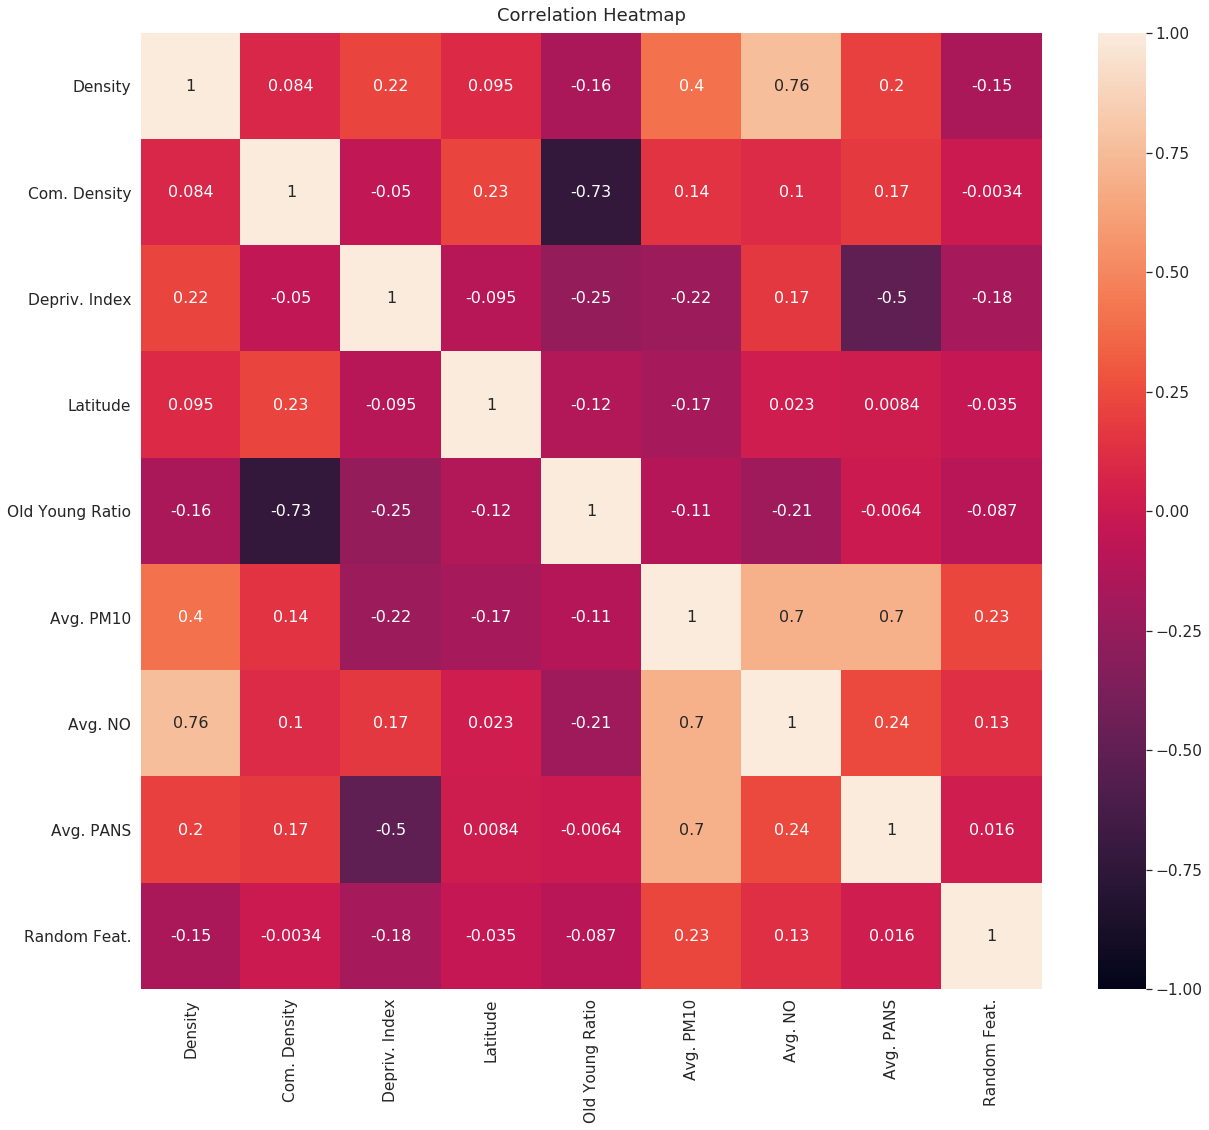

In [7]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.39592  0.04265 
    Test set average RMSE:  1.04475  0.10946 

Prediction STD :    0.72324
True value STD :    1.04859
Difference in percentage:   31.02704

             Fullset RMSE:    0.35755
                       R2:    0.88373


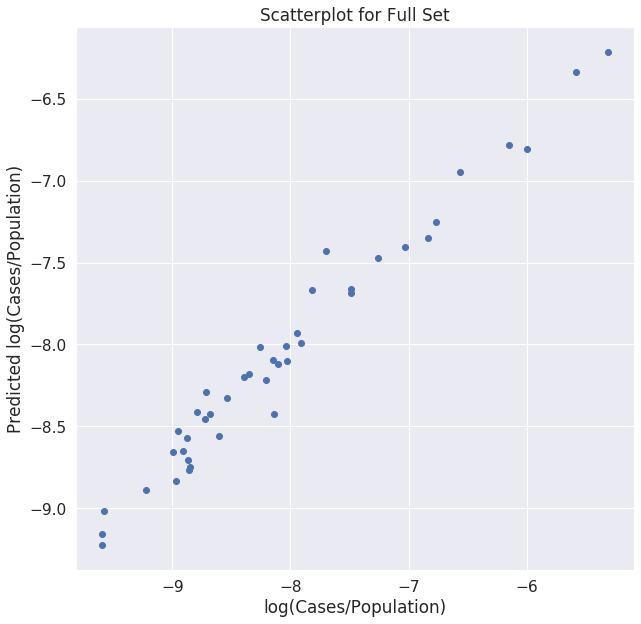

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.11087 +/- 0.01929
Feature:                Old Young Ratio, Score: 0.18724 +/- 0.03995
Feature:                      Avg. PM10, Score: 0.24469 +/- 0.03505
Feature:                        Avg. NO, Score: 0.21769 +/- 0.04010
Feature:                      Avg. PANS, Score: 0.09433 +/- 0.01325


<Figure size 432x288 with 0 Axes>

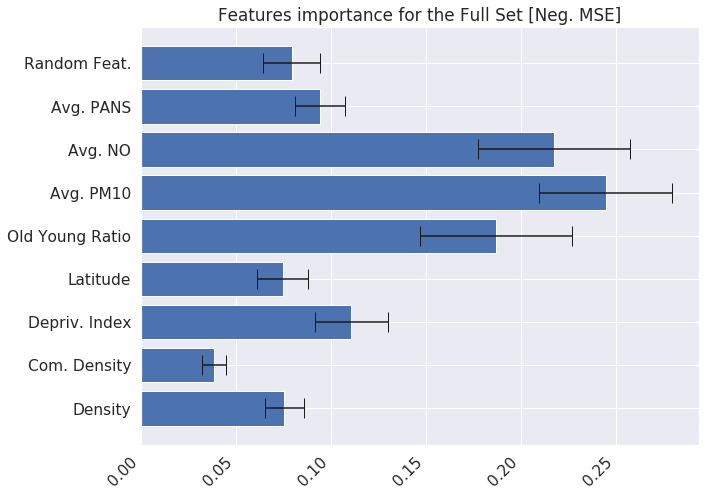

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                  Depriv. Index, Score: 0.10083 +/- 0.01755
Feature:                Old Young Ratio, Score: 0.17029 +/- 0.03633
Feature:                      Avg. PM10, Score: 0.22254 +/- 0.03188
Feature:                        Avg. NO, Score: 0.19798 +/- 0.03647
Feature:                      Avg. PANS, Score: 0.08579 +/- 0.01205


<Figure size 432x288 with 0 Axes>

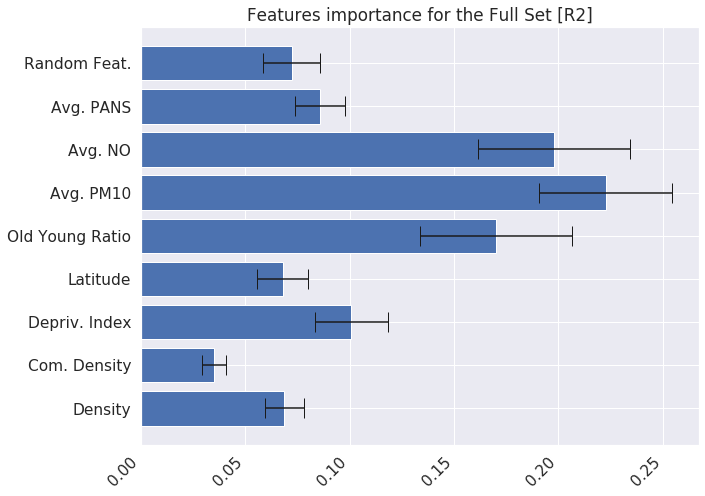

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.37709
                       R2:    0.86471


<Figure size 432x288 with 0 Axes>

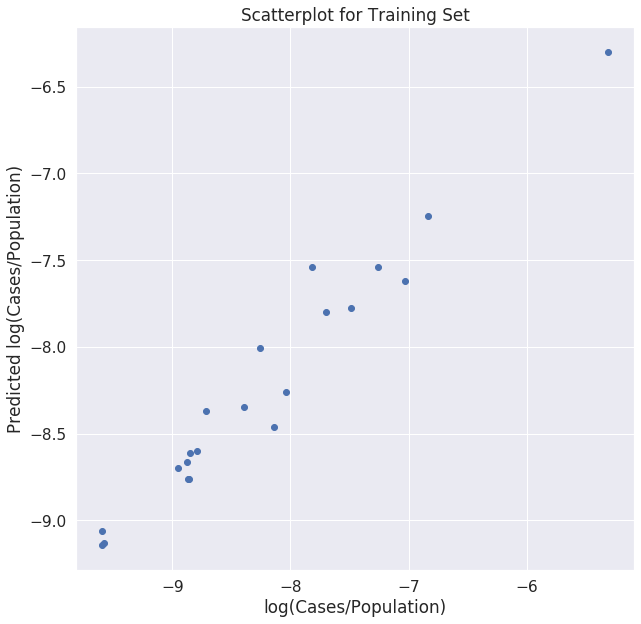

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.06659
                       R2:   -0.04217


<Figure size 432x288 with 0 Axes>

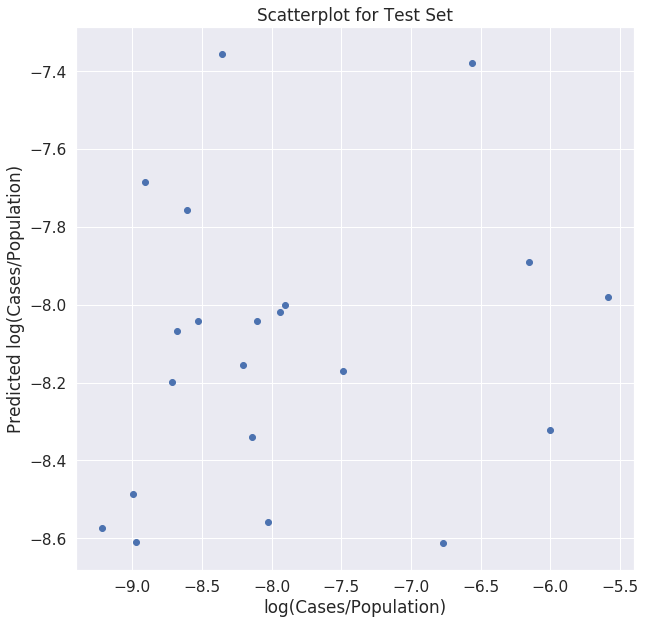

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00599 +/- 0.04509
Feature:                Old Young Ratio, Score: 0.05188 +/- 0.06360
Feature:                      Avg. PM10, Score: 0.11304 +/- 0.05164
Feature:                        Avg. NO, Score: 0.03423 +/- 0.03387
Feature:                      Avg. PANS, Score: 0.02538 +/- 0.03235


<Figure size 432x288 with 0 Axes>

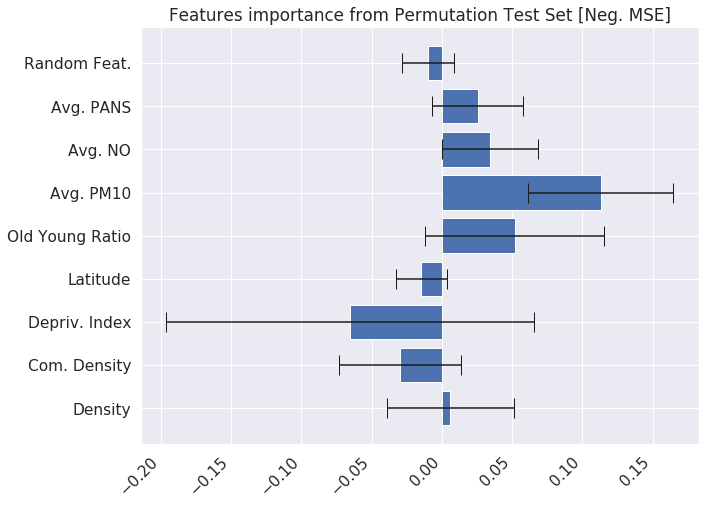

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.00549 +/- 0.04131
Feature:                Old Young Ratio, Score: 0.04753 +/- 0.05826
Feature:                      Avg. PM10, Score: 0.10356 +/- 0.04731
Feature:                        Avg. NO, Score: 0.03135 +/- 0.03103
Feature:                      Avg. PANS, Score: 0.02325 +/- 0.02963


<Figure size 432x288 with 0 Axes>

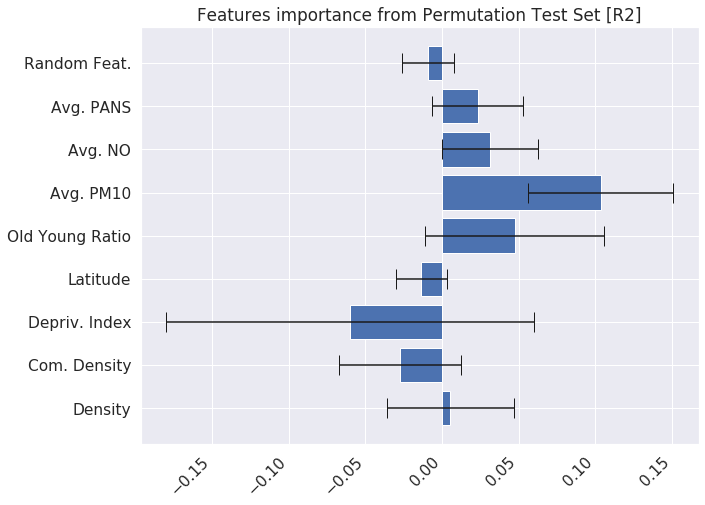

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.07299 +/- 0.01521
Feature:                   Com. Density, Score: 0.08390 +/- 0.02197
Feature:                  Depriv. Index, Score: 0.33974 +/- 0.08934
Feature:                       Latitude, Score: 0.06058 +/- 0.01120
Feature:                Old Young Ratio, Score: 0.08838 +/- 0.03197
Feature:                      Avg. PM10, Score: 0.11613 +/- 0.02795
Feature:                        Avg. NO, Score: 0.07331 +/- 0.01654
Feature:                      Avg. PANS, Score: 0.05628 +/- 0.01460


<Figure size 432x288 with 0 Axes>

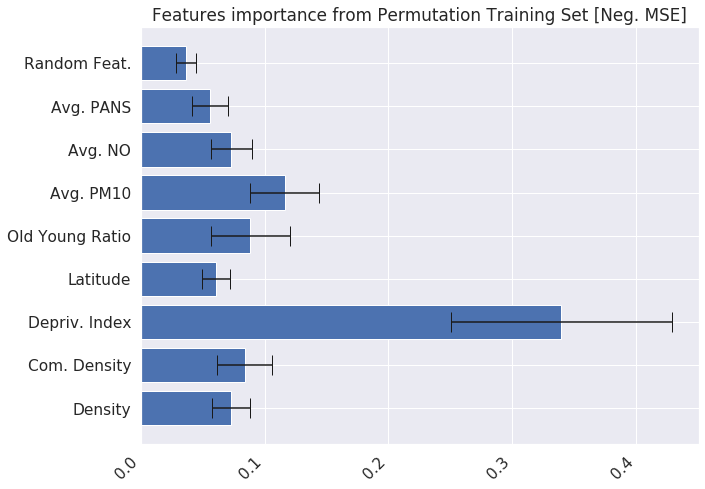

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.06945 +/- 0.01447
Feature:                   Com. Density, Score: 0.07983 +/- 0.02090
Feature:                  Depriv. Index, Score: 0.32325 +/- 0.08501
Feature:                       Latitude, Score: 0.05764 +/- 0.01065
Feature:                Old Young Ratio, Score: 0.08409 +/- 0.03042
Feature:                      Avg. PM10, Score: 0.11050 +/- 0.02659
Feature:                        Avg. NO, Score: 0.06975 +/- 0.01574
Feature:                      Avg. PANS, Score: 0.05354 +/- 0.01389


<Figure size 432x288 with 0 Axes>

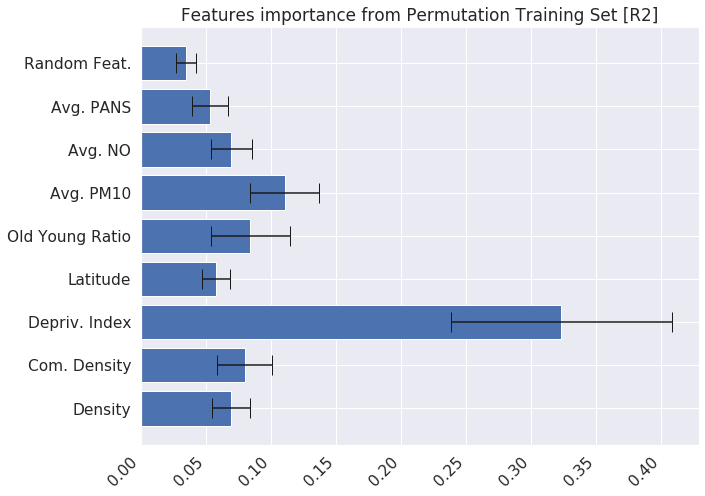

<Figure size 720x720 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.36815  0.04407 
    Test set average RMSE:  1.06331  0.12087 

Prediction STD :    0.72893
True value STD :    1.04859
Difference in percentage:   30.48435

             Fullset RMSE:    0.35213
                       R2:    0.88723


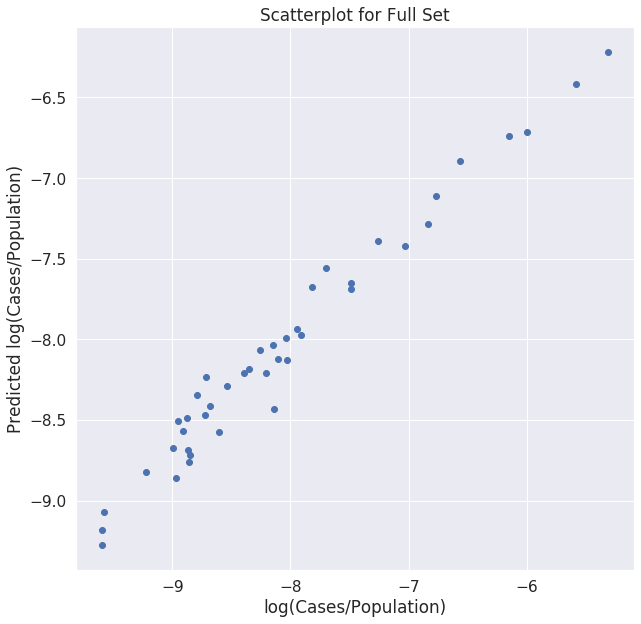

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.09429 +/- 0.01314
Feature:                  Depriv. Index, Score: 0.14302 +/- 0.02390
Feature:                Old Young Ratio, Score: 0.18862 +/- 0.03836
Feature:                      Avg. PM10, Score: 0.22910 +/- 0.02931
Feature:                        Avg. NO, Score: 0.22044 +/- 0.04066
Feature:                      Avg. PANS, Score: 0.11491 +/- 0.01472


<Figure size 432x288 with 0 Axes>

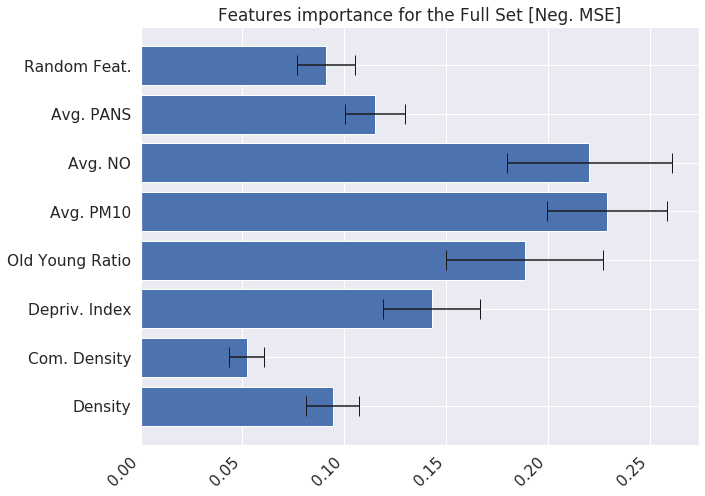

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.08576 +/- 0.01195
Feature:                  Depriv. Index, Score: 0.13007 +/- 0.02174
Feature:                Old Young Ratio, Score: 0.17154 +/- 0.03489
Feature:                      Avg. PM10, Score: 0.20836 +/- 0.02665
Feature:                        Avg. NO, Score: 0.20049 +/- 0.03698
Feature:                      Avg. PANS, Score: 0.10451 +/- 0.01339


<Figure size 432x288 with 0 Axes>

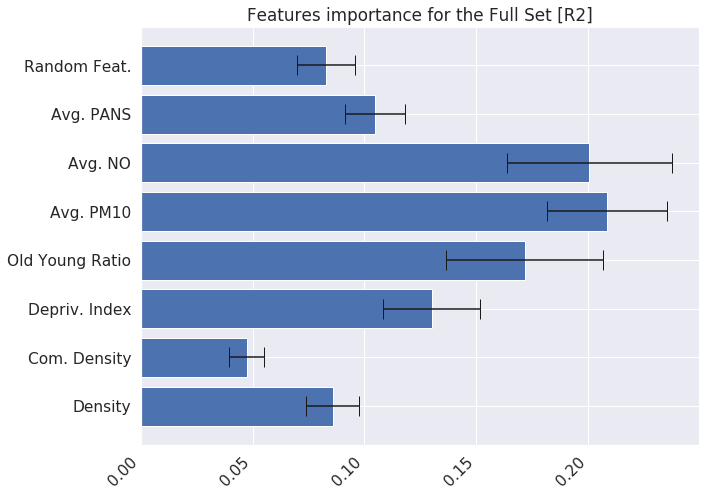

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.36808
                       R2:    0.82843


<Figure size 432x288 with 0 Axes>

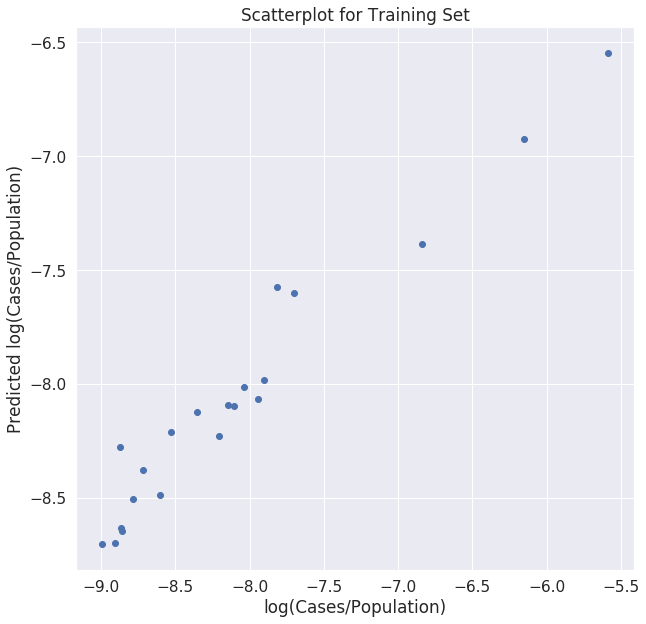

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.10865
                       R2:    0.12715


<Figure size 432x288 with 0 Axes>

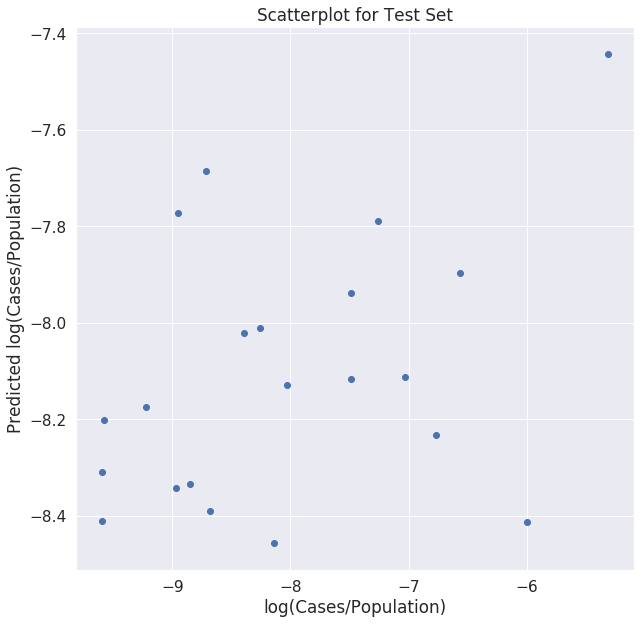

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.03775 +/- 0.03115
Feature:                   Com. Density, Score: 0.01361 +/- 0.00970
Feature:                  Depriv. Index, Score: 0.03365 +/- 0.02086
Feature:                Old Young Ratio, Score: 0.04118 +/- 0.03429
Feature:                      Avg. PM10, Score: 0.05742 +/- 0.02999
Feature:                        Avg. NO, Score: 0.07275 +/- 0.09772
Feature:                      Avg. PANS, Score: 0.00577 +/- 0.01489


<Figure size 432x288 with 0 Axes>

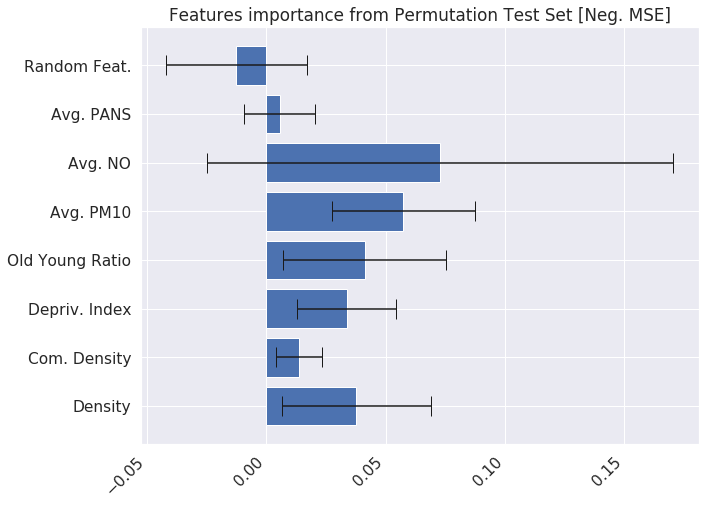

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.02681 +/- 0.02212
Feature:                   Com. Density, Score: 0.00967 +/- 0.00689
Feature:                  Depriv. Index, Score: 0.02389 +/- 0.01482
Feature:                Old Young Ratio, Score: 0.02924 +/- 0.02435
Feature:                      Avg. PM10, Score: 0.04078 +/- 0.02130
Feature:                        Avg. NO, Score: 0.05166 +/- 0.06939
Feature:                      Avg. PANS, Score: 0.00409 +/- 0.01057


<Figure size 432x288 with 0 Axes>

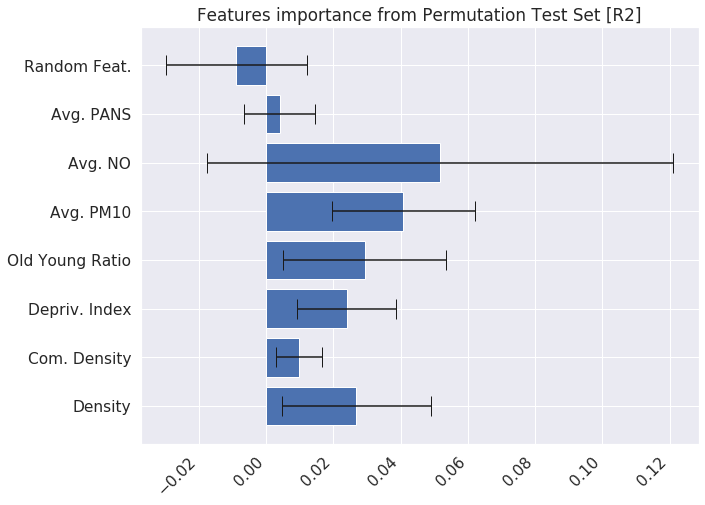

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.08514 +/- 0.01868
Feature:                Old Young Ratio, Score: 0.12303 +/- 0.03233
Feature:                      Avg. PM10, Score: 0.14873 +/- 0.03310
Feature:                        Avg. NO, Score: 0.15683 +/- 0.04609


<Figure size 432x288 with 0 Axes>

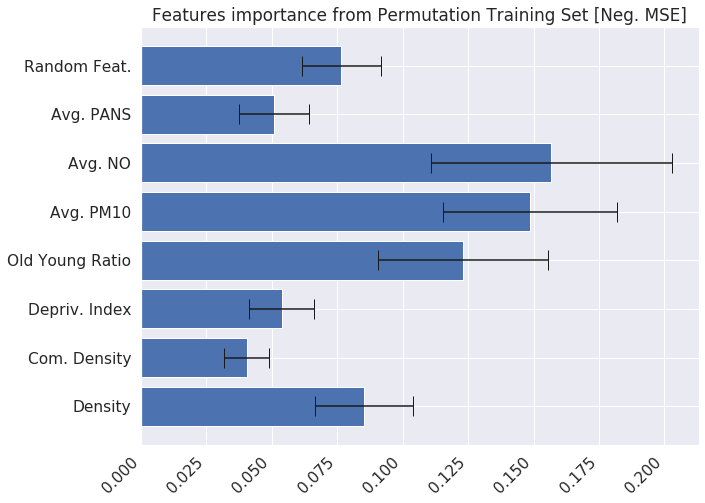

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.10782 +/- 0.02366
Feature:                Old Young Ratio, Score: 0.15580 +/- 0.04094
Feature:                      Avg. PM10, Score: 0.18834 +/- 0.04192
Feature:                        Avg. NO, Score: 0.19860 +/- 0.05837


<Figure size 432x288 with 0 Axes>

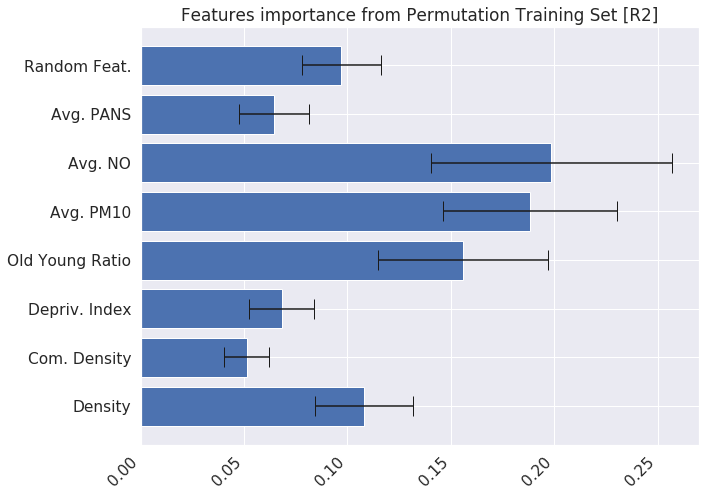

<Figure size 720x720 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37920  0.05511 
    Test set average RMSE:  1.03709  0.12195 

Prediction STD :    0.73473
True value STD :    1.04859
Difference in percentage:   29.93131

             Fullset RMSE:    0.35252
                       R2:    0.88698


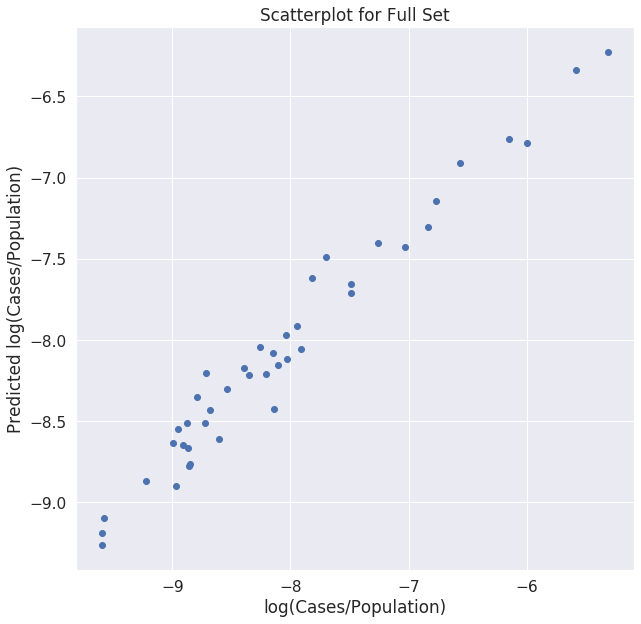

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.10710 +/- 0.01563
Feature:                  Depriv. Index, Score: 0.15955 +/- 0.02726
Feature:                Old Young Ratio, Score: 0.18267 +/- 0.03606
Feature:                      Avg. PM10, Score: 0.25530 +/- 0.03643
Feature:                        Avg. NO, Score: 0.23690 +/- 0.04274
Feature:                      Avg. PANS, Score: 0.11787 +/- 0.01514


<Figure size 432x288 with 0 Axes>

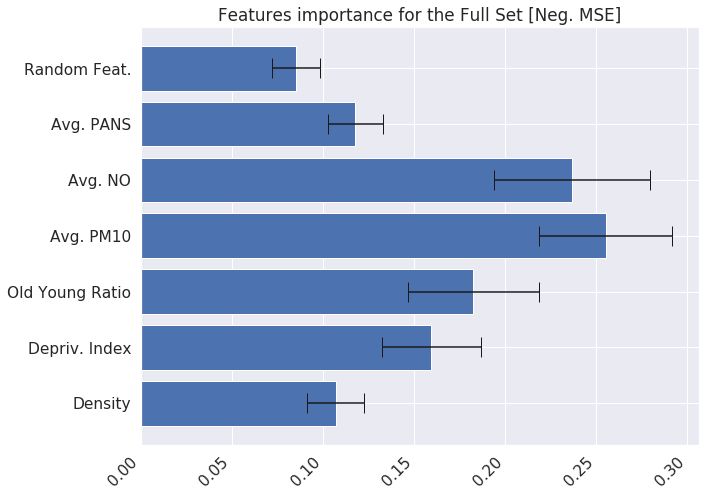

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.09741 +/- 0.01421
Feature:                  Depriv. Index, Score: 0.14511 +/- 0.02480
Feature:                Old Young Ratio, Score: 0.16614 +/- 0.03280
Feature:                      Avg. PM10, Score: 0.23219 +/- 0.03313
Feature:                        Avg. NO, Score: 0.21545 +/- 0.03887
Feature:                      Avg. PANS, Score: 0.10720 +/- 0.01377


<Figure size 432x288 with 0 Axes>

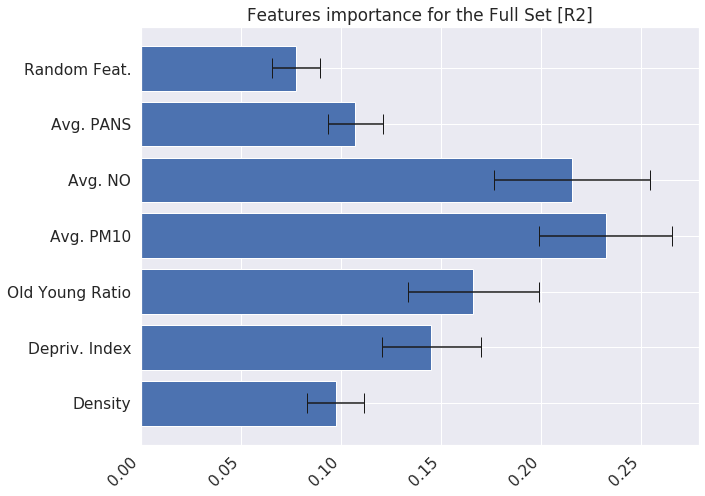

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.39716
                       R2:    0.88475


<Figure size 432x288 with 0 Axes>

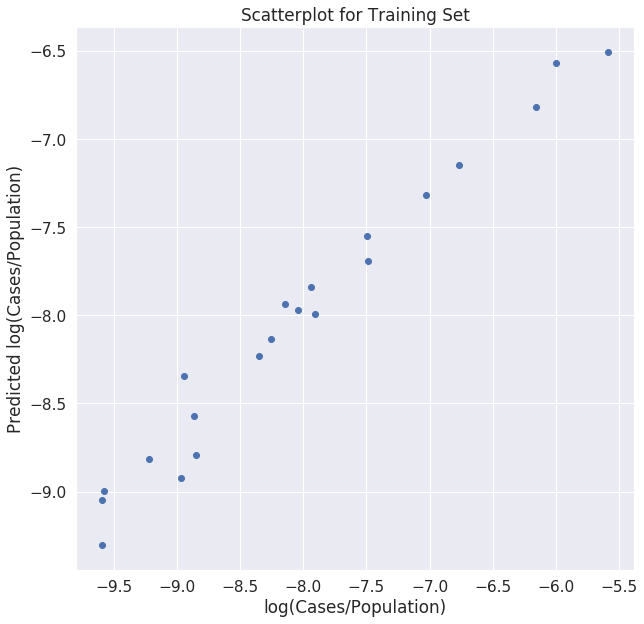

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.96622
                       R2:   -0.12661


<Figure size 432x288 with 0 Axes>

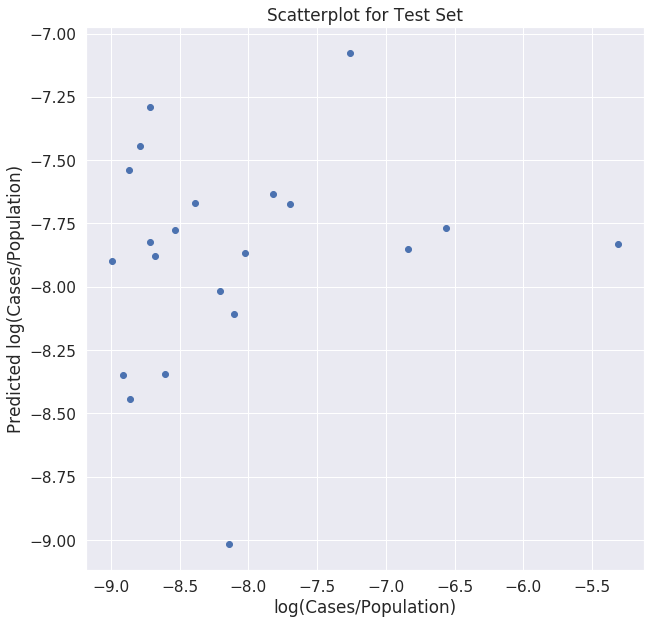

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                Old Young Ratio, Score: 0.01025 +/- 0.04056
Feature:                      Avg. PM10, Score: 0.07448 +/- 0.03863
Feature:                        Avg. NO, Score: 0.10654 +/- 0.09863


<Figure size 432x288 with 0 Axes>

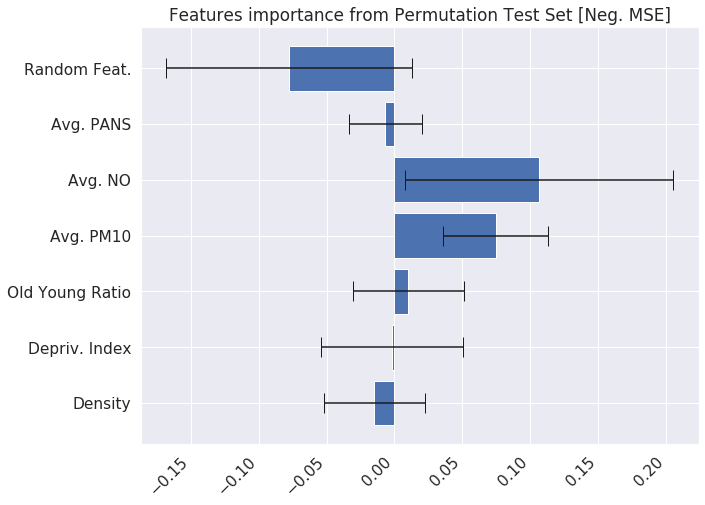

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                Old Young Ratio, Score: 0.01237 +/- 0.04894
Feature:                      Avg. PM10, Score: 0.08987 +/- 0.04662
Feature:                        Avg. NO, Score: 0.12856 +/- 0.11902


<Figure size 432x288 with 0 Axes>

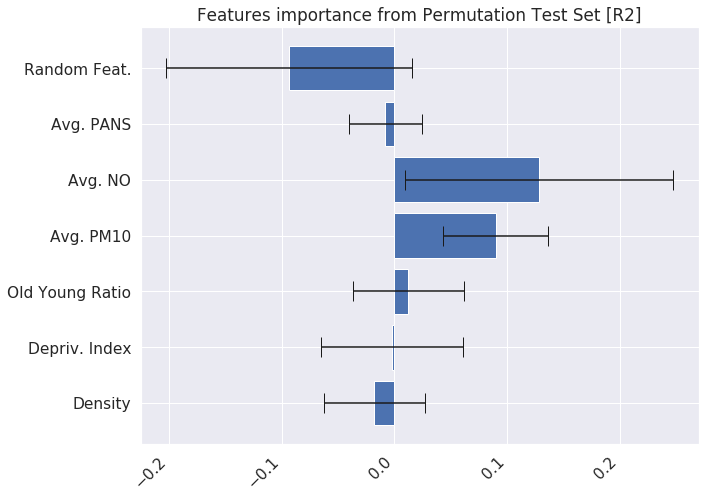

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.24461 +/- 0.07106
Feature:                        Avg. NO, Score: 0.28504 +/- 0.08467


<Figure size 432x288 with 0 Axes>

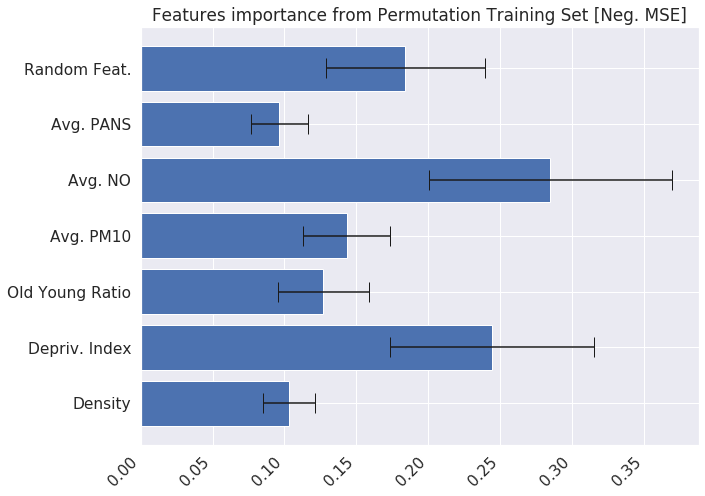

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                  Depriv. Index, Score: 0.17873 +/- 0.05192
Feature:                        Avg. NO, Score: 0.20828 +/- 0.06187


<Figure size 432x288 with 0 Axes>

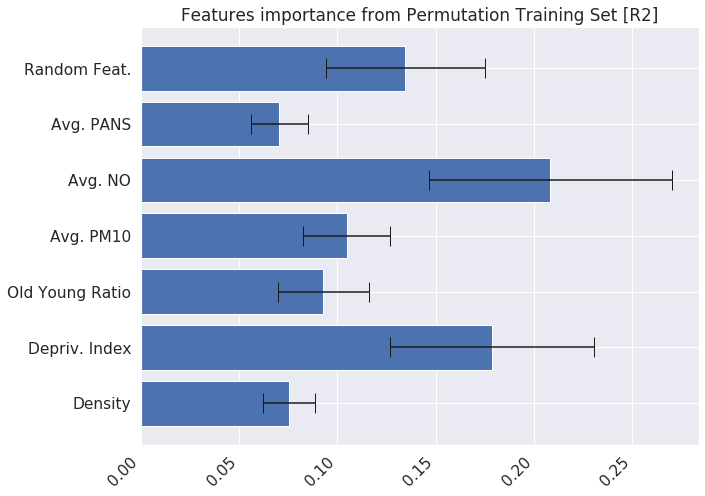

<Figure size 720x720 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Training Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37499  0.05216 
    Test set average RMSE:  1.08853  0.12466 

Prediction STD :    0.72026
True value STD :    1.04859
Difference in percentage:   31.31174

             Fullset RMSE:    0.36230
                       R2:    0.88062


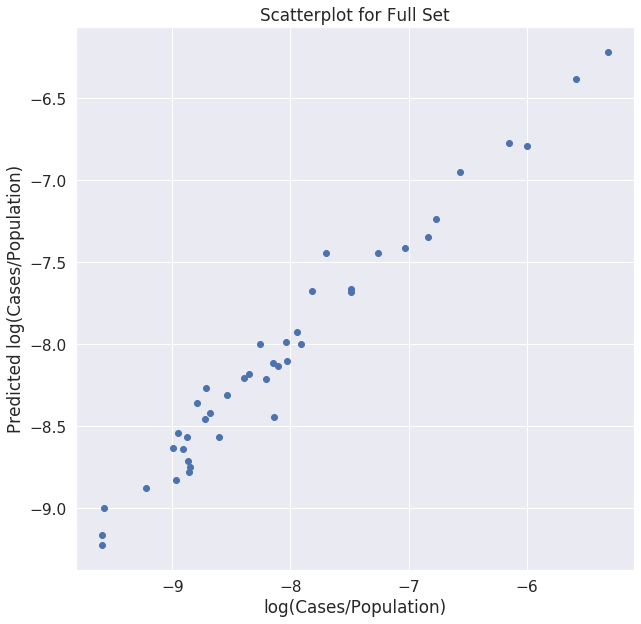

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.11278 +/- 0.02010
Feature:                Old Young Ratio, Score: 0.18795 +/- 0.03989
Feature:                      Avg. PM10, Score: 0.23587 +/- 0.03380
Feature:                        Avg. NO, Score: 0.22169 +/- 0.04110
Feature:                      Avg. PANS, Score: 0.09196 +/- 0.01290


<Figure size 432x288 with 0 Axes>

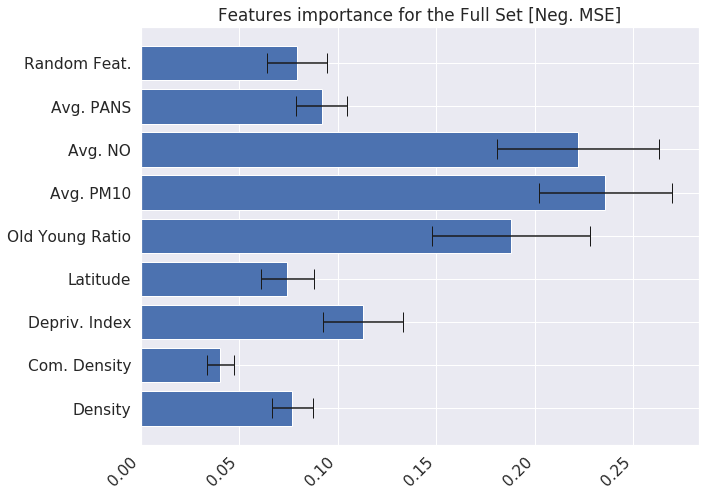

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                  Depriv. Index, Score: 0.10257 +/- 0.01828
Feature:                Old Young Ratio, Score: 0.17094 +/- 0.03628
Feature:                      Avg. PM10, Score: 0.21452 +/- 0.03074
Feature:                        Avg. NO, Score: 0.20162 +/- 0.03738
Feature:                      Avg. PANS, Score: 0.08363 +/- 0.01173


<Figure size 432x288 with 0 Axes>

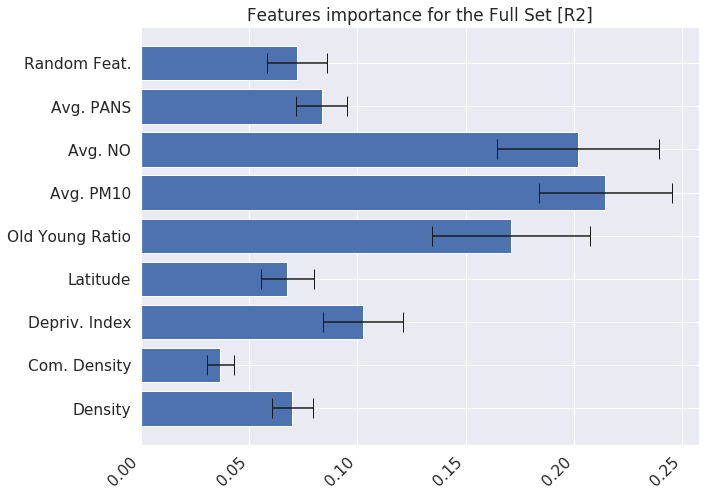

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.25629
                       R2:    0.88355


<Figure size 432x288 with 0 Axes>

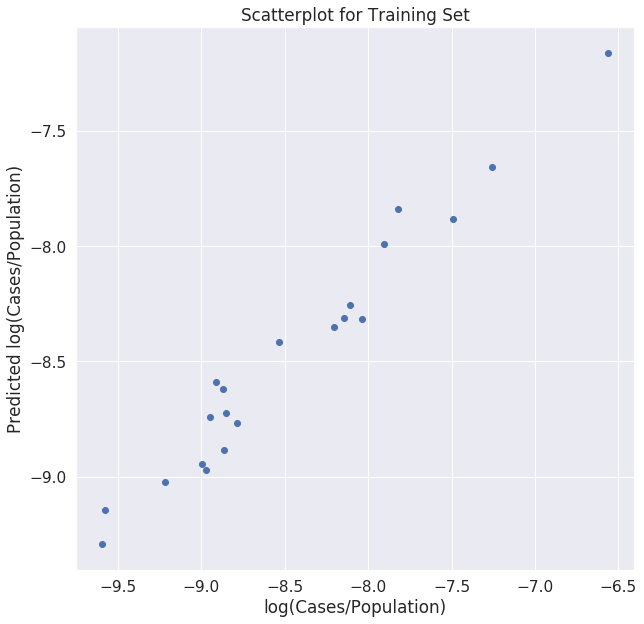

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.34630
                       R2:   -0.36521


<Figure size 432x288 with 0 Axes>

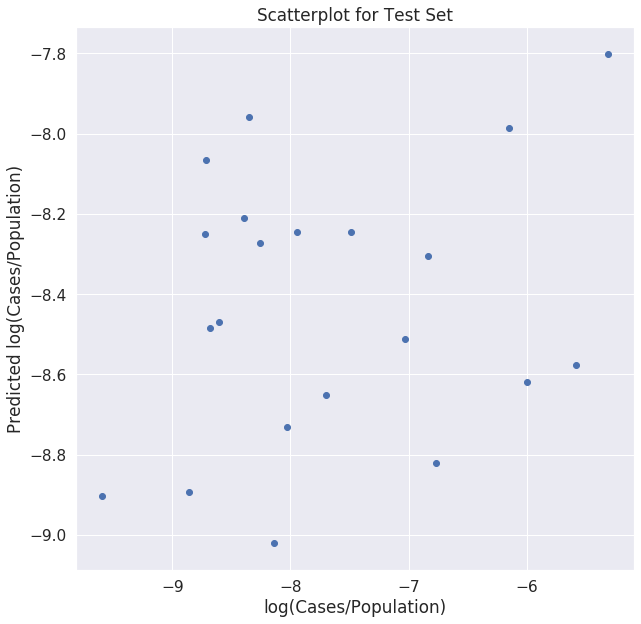

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.07953 +/- 0.06563
Feature:                      Avg. PM10, Score: 0.02509 +/- 0.01814
Feature:                        Avg. NO, Score: 0.06722 +/- 0.05632
Feature:                      Avg. PANS, Score: 0.02452 +/- 0.02275


<Figure size 432x288 with 0 Axes>

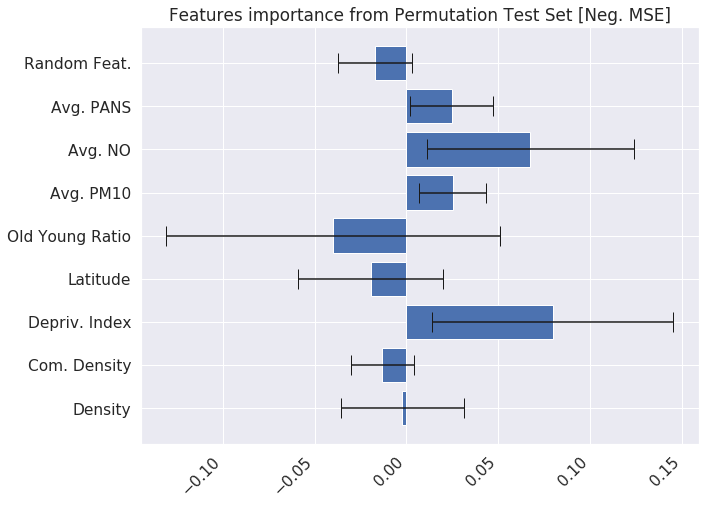

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.05991 +/- 0.04943
Feature:                      Avg. PM10, Score: 0.01890 +/- 0.01366
Feature:                        Avg. NO, Score: 0.05063 +/- 0.04242
Feature:                      Avg. PANS, Score: 0.01847 +/- 0.01714


<Figure size 432x288 with 0 Axes>

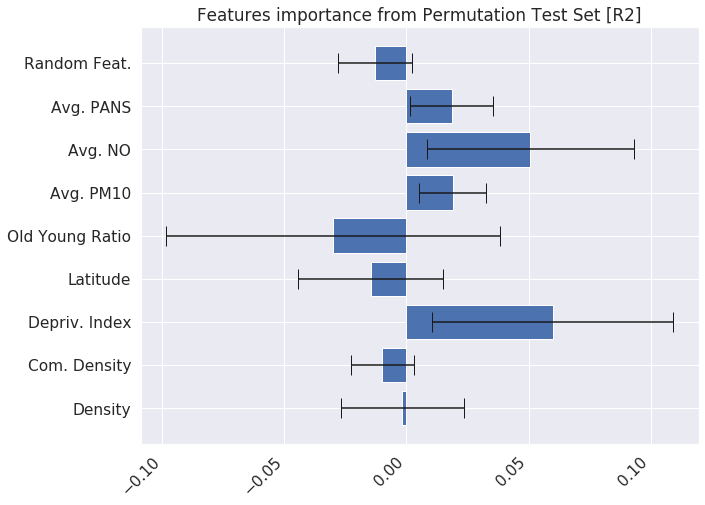

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.03448 +/- 0.00987
Feature:                  Depriv. Index, Score: 0.10093 +/- 0.03085
Feature:                       Latitude, Score: 0.04817 +/- 0.01554
Feature:                Old Young Ratio, Score: 0.09729 +/- 0.02868
Feature:                        Avg. NO, Score: 0.05175 +/- 0.01700


<Figure size 432x288 with 0 Axes>

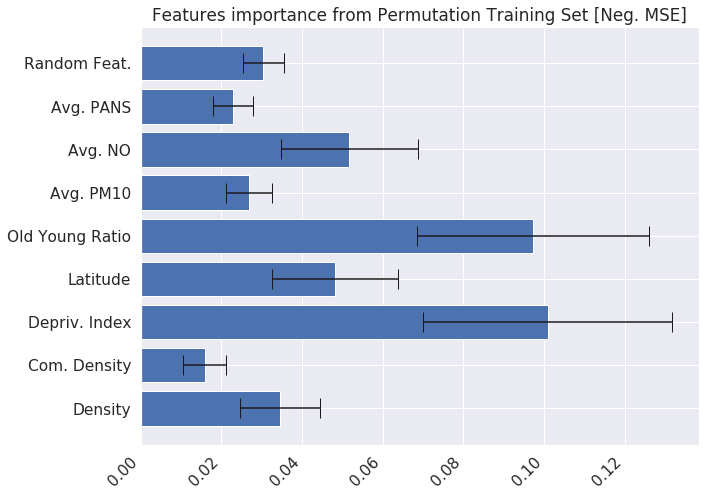

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.06114 +/- 0.01750
Feature:                  Depriv. Index, Score: 0.17895 +/- 0.05469
Feature:                       Latitude, Score: 0.08541 +/- 0.02756
Feature:                Old Young Ratio, Score: 0.17249 +/- 0.05086
Feature:                        Avg. NO, Score: 0.09175 +/- 0.03014


<Figure size 432x288 with 0 Axes>

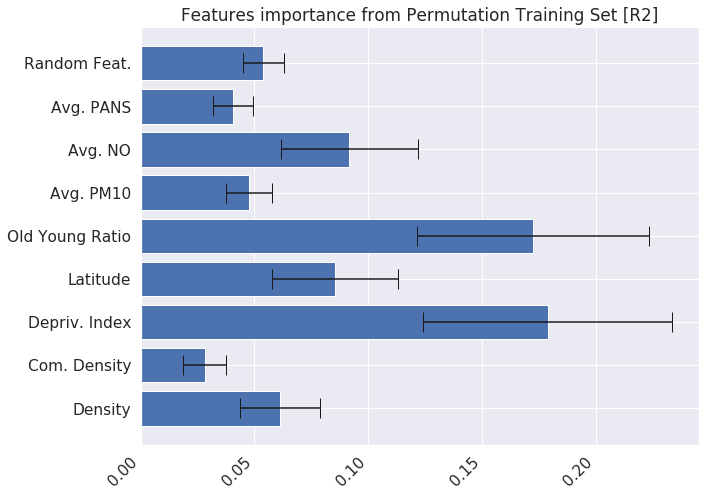

<Figure size 720x720 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.36991  0.05403 
    Test set average RMSE:  1.05496  0.13588 

Prediction STD :    0.72698
True value STD :    1.04859
Difference in percentage:   30.67026

             Fullset RMSE:    0.35509
                       R2:    0.88533


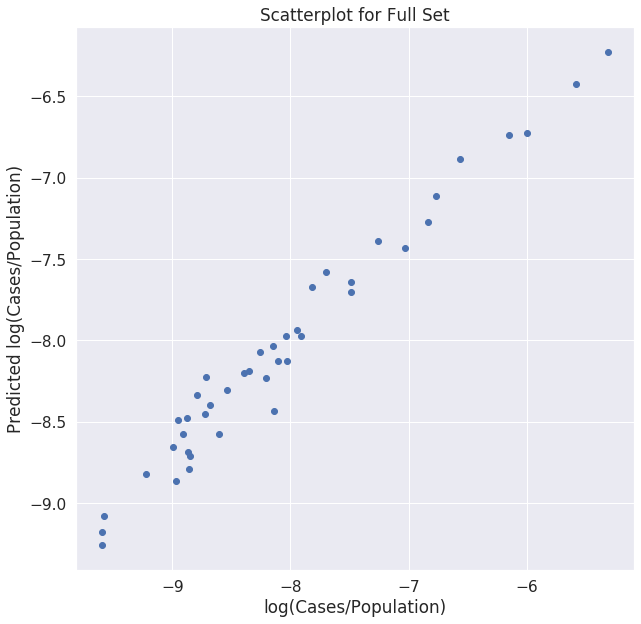

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.09168 +/- 0.01257
Feature:                  Depriv. Index, Score: 0.14458 +/- 0.02357
Feature:                Old Young Ratio, Score: 0.18584 +/- 0.03720
Feature:                      Avg. PM10, Score: 0.22665 +/- 0.02875
Feature:                        Avg. NO, Score: 0.22413 +/- 0.04111
Feature:                      Avg. PANS, Score: 0.11485 +/- 0.01451


<Figure size 432x288 with 0 Axes>

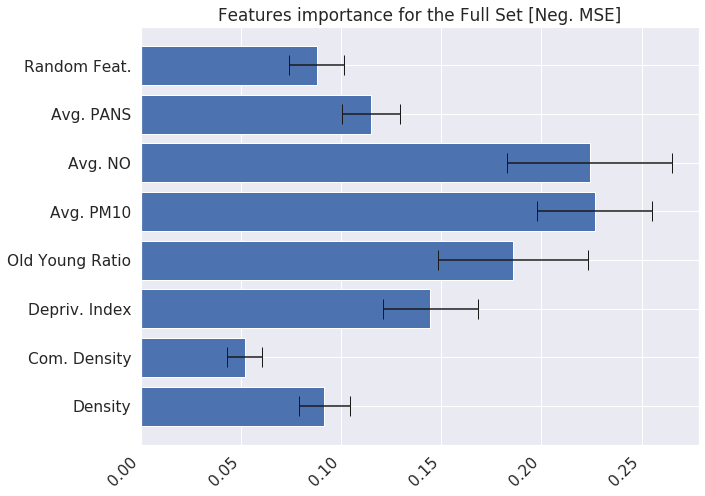

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.08338 +/- 0.01143
Feature:                  Depriv. Index, Score: 0.13149 +/- 0.02143
Feature:                Old Young Ratio, Score: 0.16902 +/- 0.03383
Feature:                      Avg. PM10, Score: 0.20613 +/- 0.02615
Feature:                        Avg. NO, Score: 0.20384 +/- 0.03739
Feature:                      Avg. PANS, Score: 0.10445 +/- 0.01320


<Figure size 432x288 with 0 Axes>

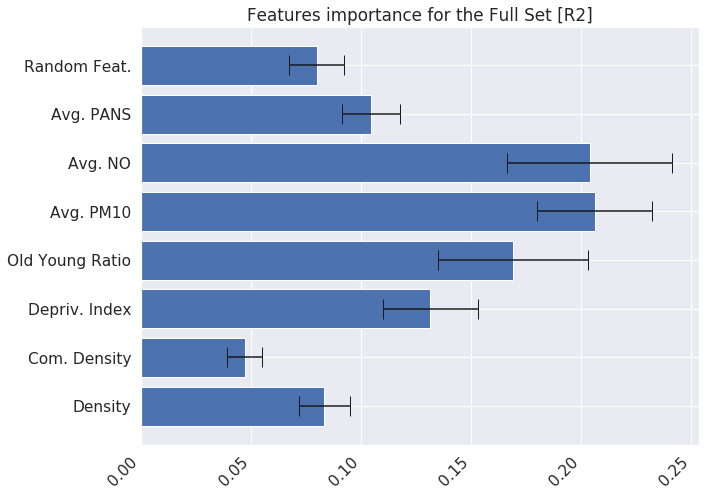

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.33671
                       R2:    0.85299


<Figure size 432x288 with 0 Axes>

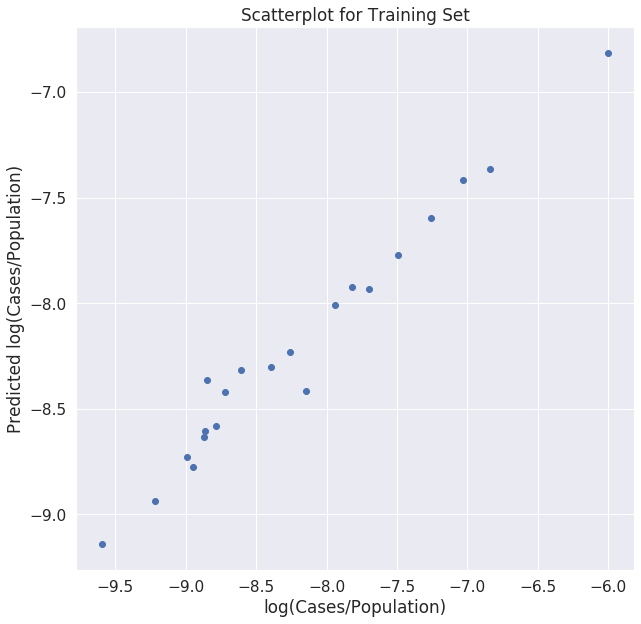

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.18442
                       R2:   -0.00960


<Figure size 432x288 with 0 Axes>

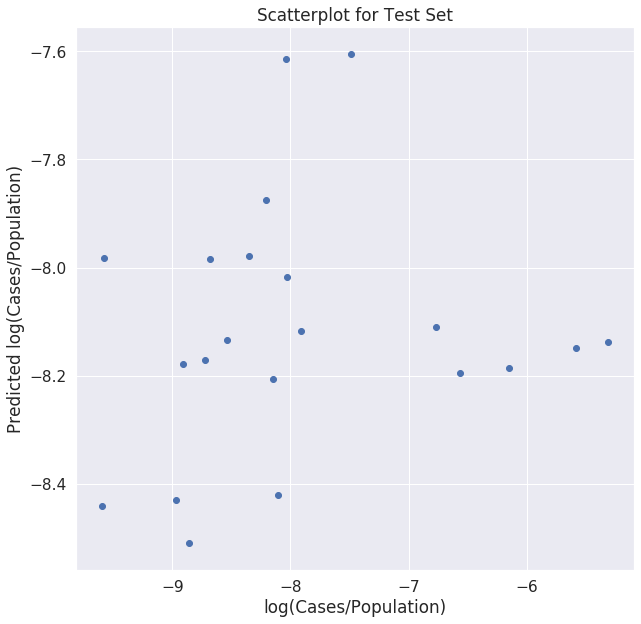

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.02434 +/- 0.03499
Feature:                Old Young Ratio, Score: 0.02399 +/- 0.03008
Feature:                      Avg. PM10, Score: 0.16127 +/- 0.05038
Feature:                        Avg. NO, Score: 0.03099 +/- 0.03194


<Figure size 432x288 with 0 Axes>

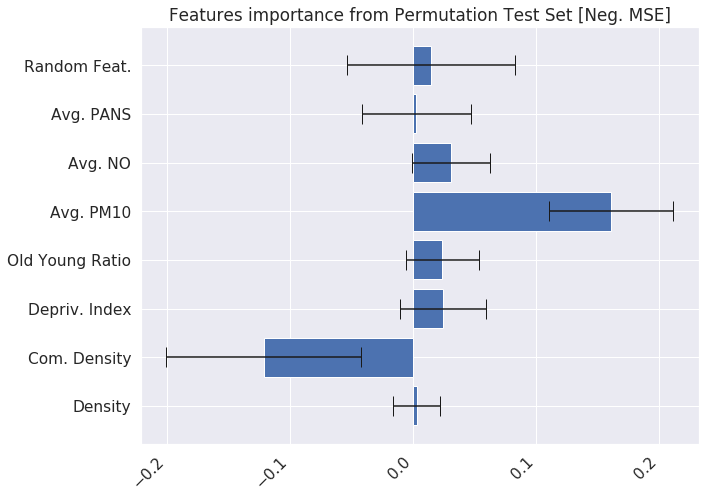

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.01752 +/- 0.02518
Feature:                Old Young Ratio, Score: 0.01726 +/- 0.02164
Feature:                      Avg. PM10, Score: 0.11606 +/- 0.03626
Feature:                        Avg. NO, Score: 0.02231 +/- 0.02299


<Figure size 432x288 with 0 Axes>

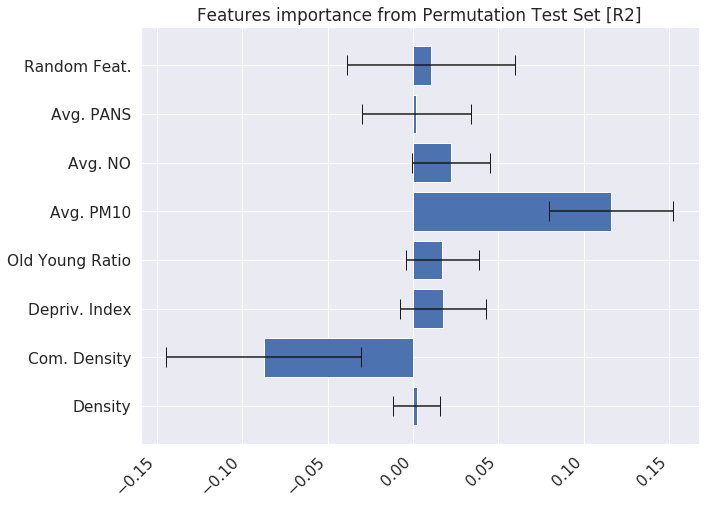

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.11777 +/- 0.03236


<Figure size 432x288 with 0 Axes>

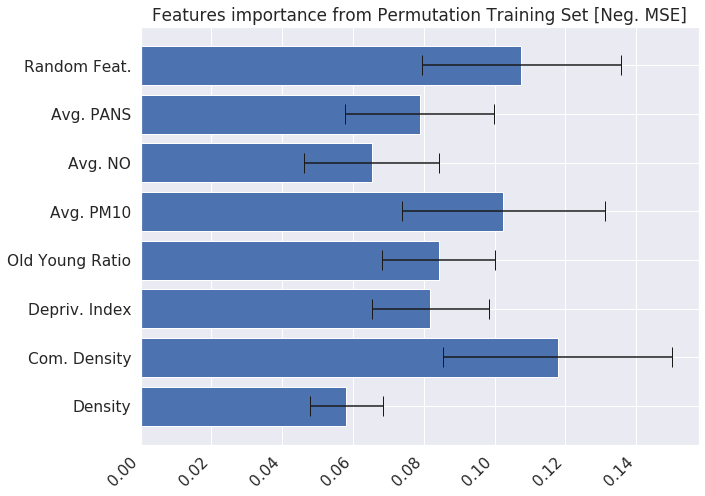

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.15272 +/- 0.04195


<Figure size 432x288 with 0 Axes>

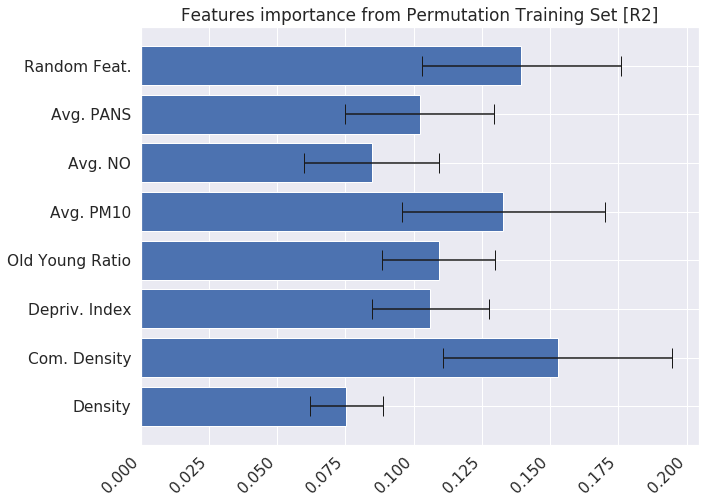

<Figure size 720x720 with 0 Axes>

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_traininingset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.38158  0.04611 
    Test set average RMSE:  1.04764  0.11836 

Prediction STD :    0.72117
True value STD :    1.04859
Difference in percentage:   31.22416

             Fullset RMSE:    0.36453
                       R2:    0.87915


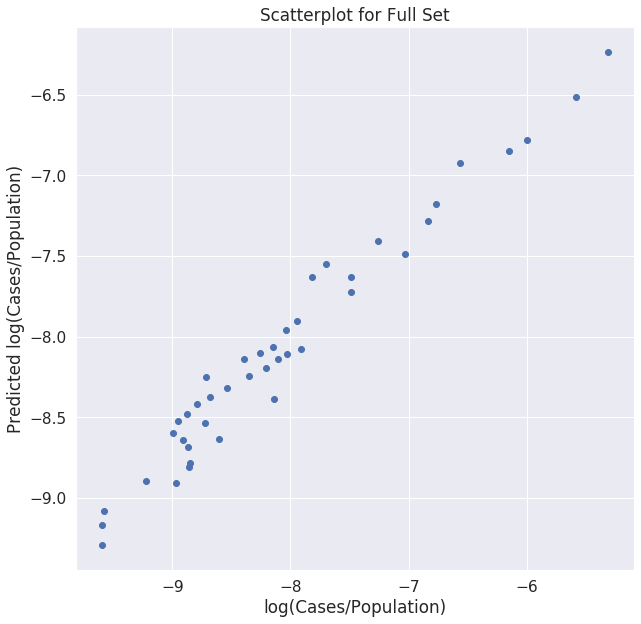

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.10336 +/- 0.01474
Feature:                  Depriv. Index, Score: 0.16635 +/- 0.02935
Feature:                Old Young Ratio, Score: 0.19365 +/- 0.03856
Feature:                      Avg. PM10, Score: 0.23632 +/- 0.03223
Feature:                        Avg. NO, Score: 0.23352 +/- 0.04373
Feature:                      Avg. PANS, Score: 0.12695 +/- 0.01748


<Figure size 432x288 with 0 Axes>

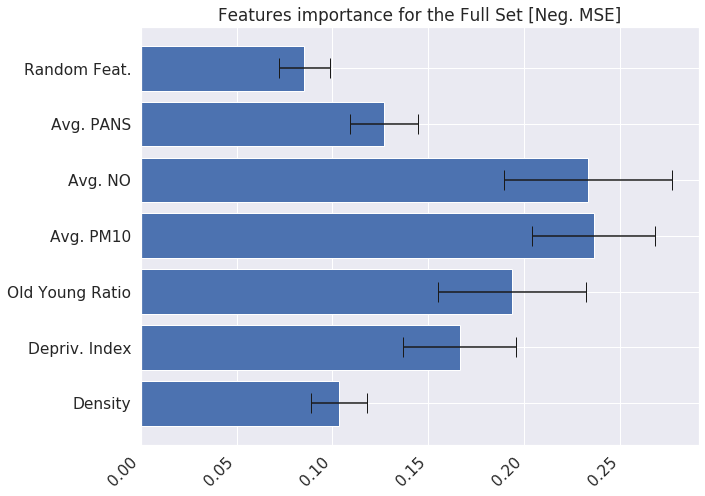

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.09400 +/- 0.01341
Feature:                  Depriv. Index, Score: 0.15130 +/- 0.02669
Feature:                Old Young Ratio, Score: 0.17612 +/- 0.03507
Feature:                      Avg. PM10, Score: 0.21493 +/- 0.02931
Feature:                        Avg. NO, Score: 0.21238 +/- 0.03978
Feature:                      Avg. PANS, Score: 0.11546 +/- 0.01590


<Figure size 432x288 with 0 Axes>

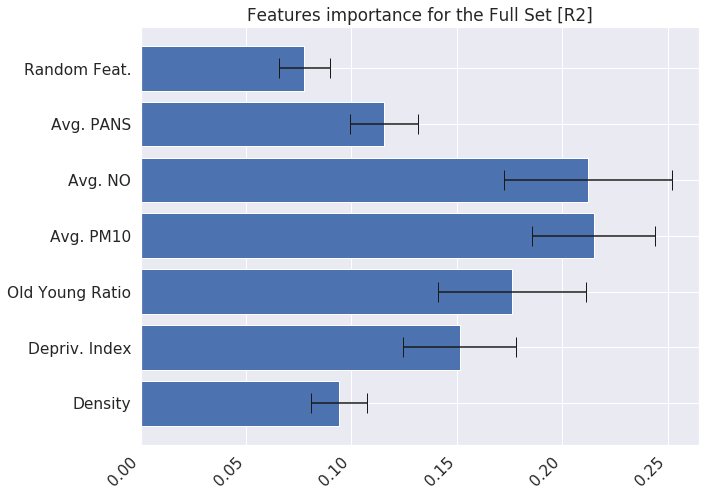

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.35018
                       R2:    0.85323


<Figure size 432x288 with 0 Axes>

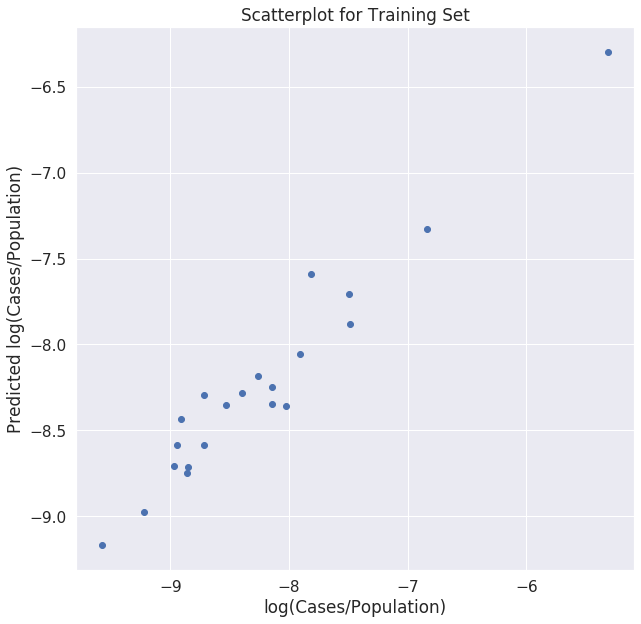

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.14193
                       R2:   -0.00214


<Figure size 432x288 with 0 Axes>

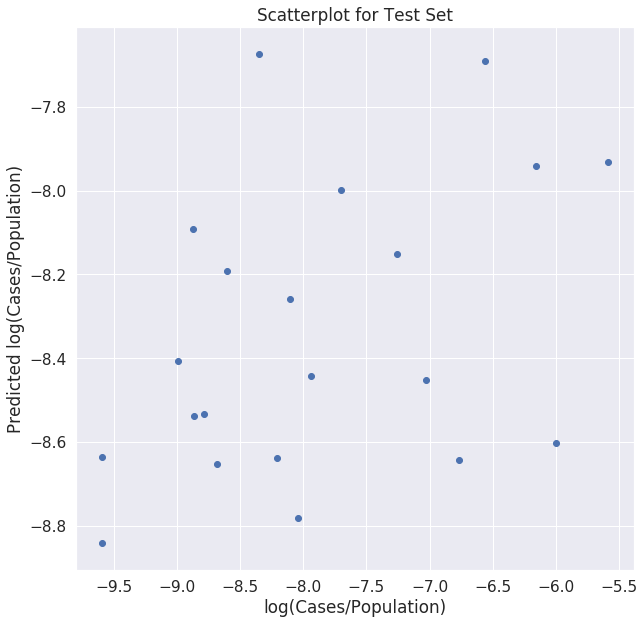

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.03428 +/- 0.04668
Feature:                Old Young Ratio, Score: 0.09001 +/- 0.06487
Feature:                      Avg. PM10, Score: 0.16451 +/- 0.08768
Feature:                        Avg. NO, Score: 0.01492 +/- 0.02877
Feature:                      Avg. PANS, Score: 0.00934 +/- 0.01675


<Figure size 432x288 with 0 Axes>

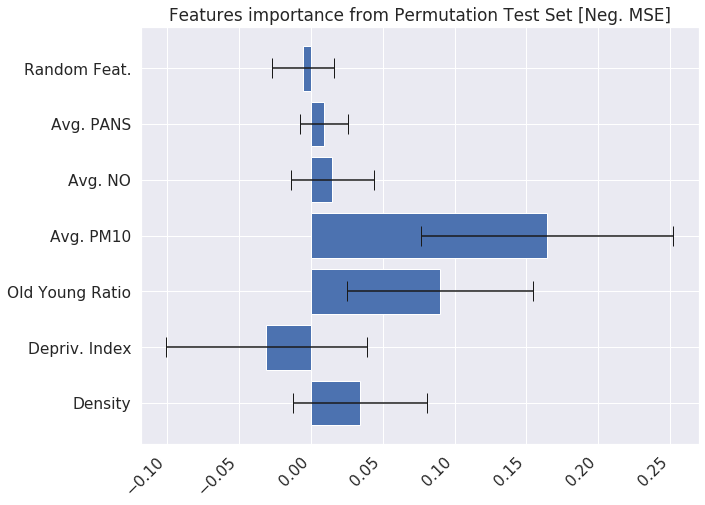

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.02635 +/- 0.03587
Feature:                Old Young Ratio, Score: 0.06917 +/- 0.04985
Feature:                      Avg. PM10, Score: 0.12643 +/- 0.06738
Feature:                        Avg. NO, Score: 0.01147 +/- 0.02211
Feature:                      Avg. PANS, Score: 0.00717 +/- 0.01287


<Figure size 432x288 with 0 Axes>

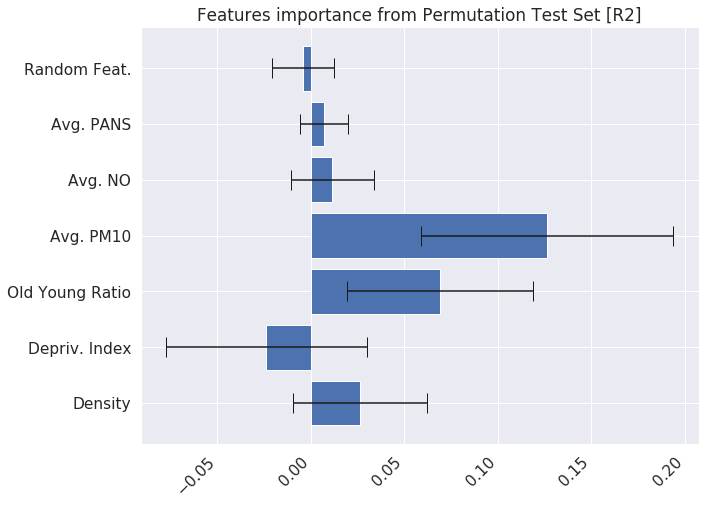

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.09909 +/- 0.02819
Feature:                  Depriv. Index, Score: 0.15266 +/- 0.03958
Feature:                Old Young Ratio, Score: 0.13590 +/- 0.03149
Feature:                      Avg. PM10, Score: 0.13092 +/- 0.02589
Feature:                        Avg. NO, Score: 0.09660 +/- 0.02552


<Figure size 432x288 with 0 Axes>

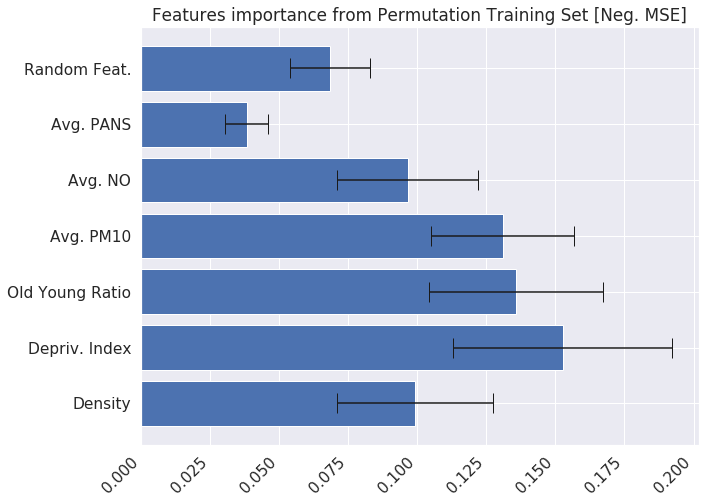

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.11860 +/- 0.03374
Feature:                  Depriv. Index, Score: 0.18272 +/- 0.04738
Feature:                Old Young Ratio, Score: 0.16266 +/- 0.03769
Feature:                      Avg. PM10, Score: 0.15670 +/- 0.03098
Feature:                        Avg. NO, Score: 0.11563 +/- 0.03055


<Figure size 432x288 with 0 Axes>

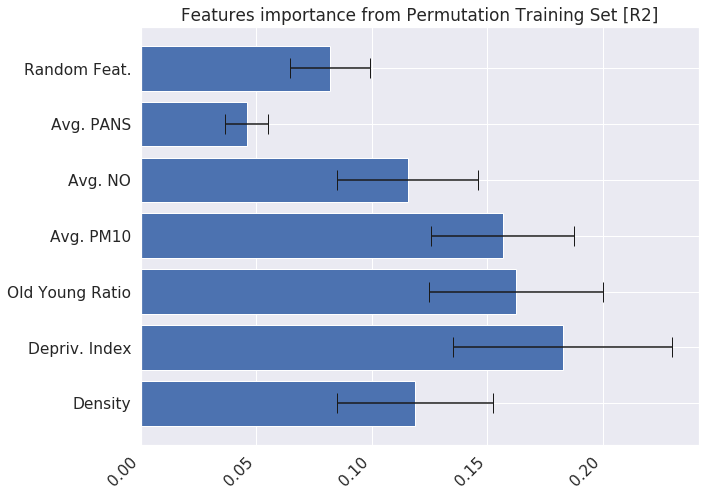

<Figure size 720x720 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Test Set 

Starting ...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.39006  0.06392 
    Test set average RMSE:  1.10766  0.14357 

Prediction STD :    0.72693
True value STD :    1.04859
Difference in percentage:   30.67561

             Fullset RMSE:    0.36817
                       R2:    0.87672


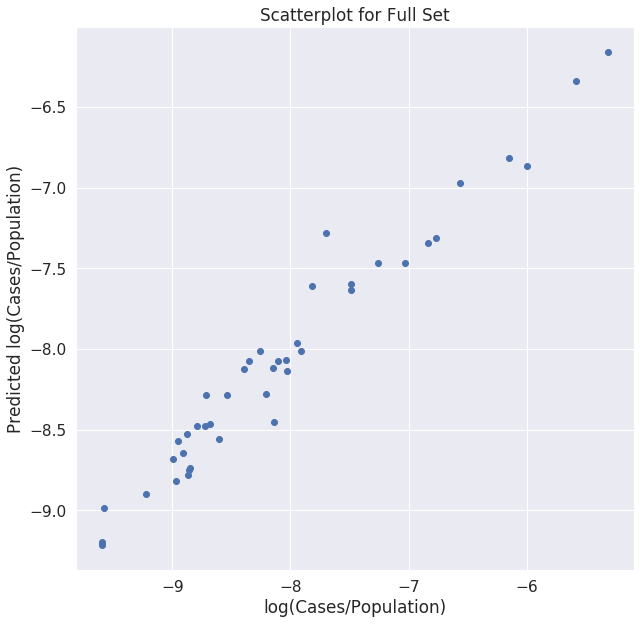

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                Old Young Ratio, Score: 0.25902 +/- 0.05799
Feature:                      Avg. PM10, Score: 0.34285 +/- 0.05901
Feature:                        Avg. NO, Score: 0.21033 +/- 0.04129


<Figure size 432x288 with 0 Axes>

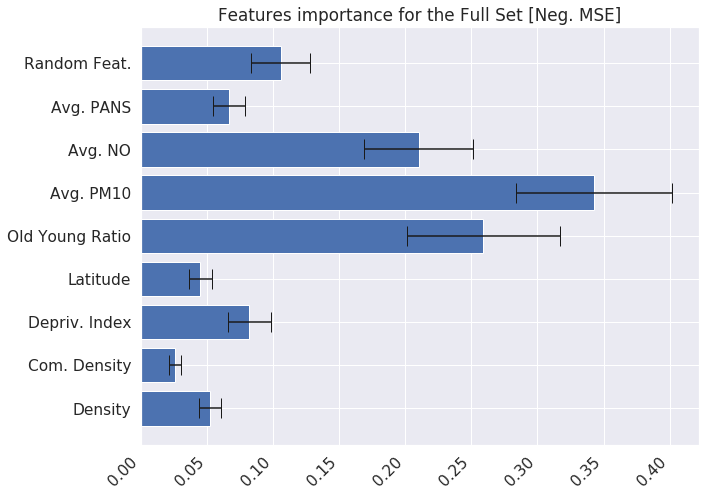

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                Old Young Ratio, Score: 0.23557 +/- 0.05274
Feature:                      Avg. PM10, Score: 0.31181 +/- 0.05367
Feature:                        Avg. NO, Score: 0.19129 +/- 0.03756


<Figure size 432x288 with 0 Axes>

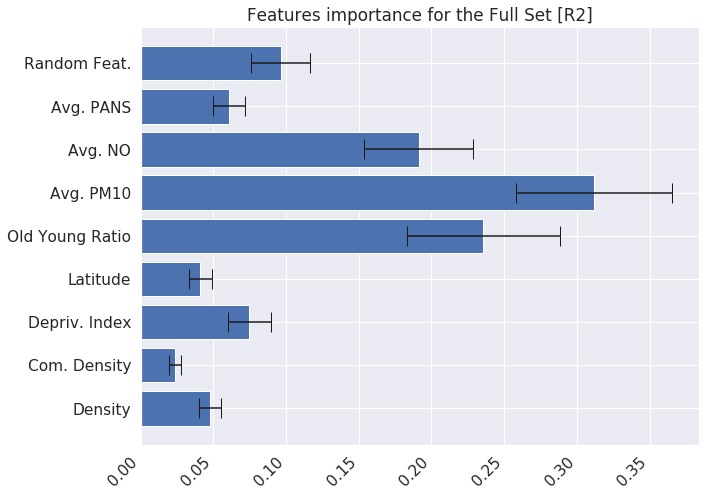

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.44075
                       R2:    0.84182


<Figure size 432x288 with 0 Axes>

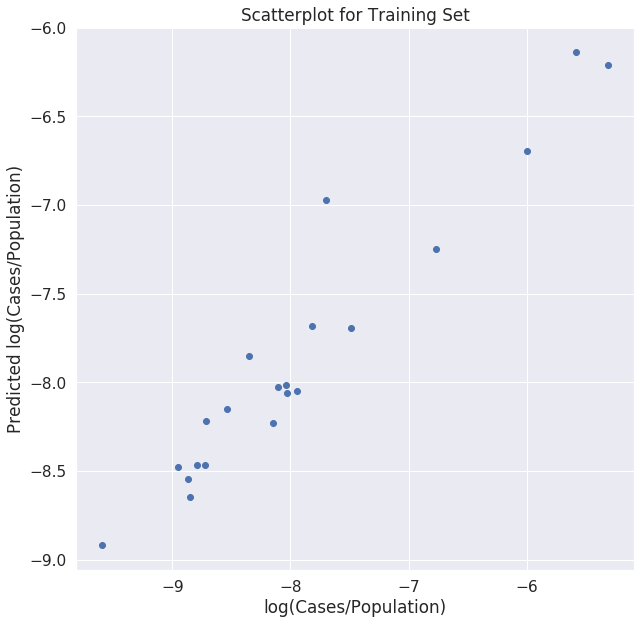

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.04075
                       R2:   -0.16825


<Figure size 432x288 with 0 Axes>

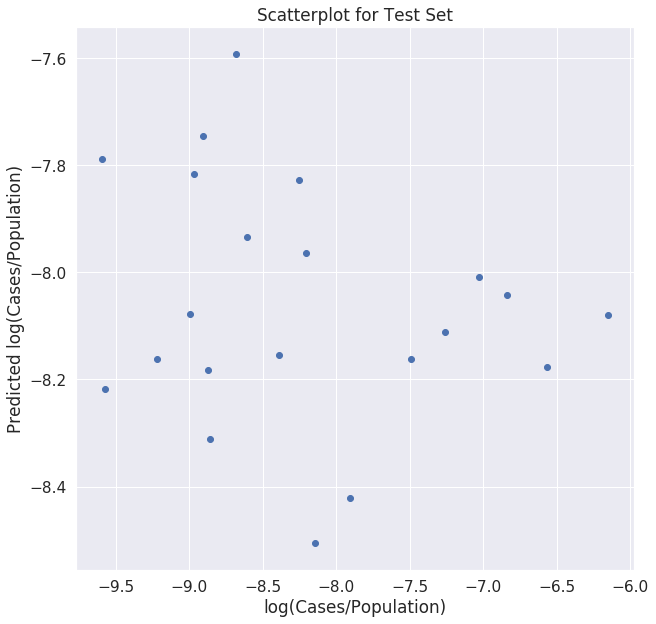

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                Old Young Ratio, Score: 0.07428 +/- 0.04308


<Figure size 432x288 with 0 Axes>

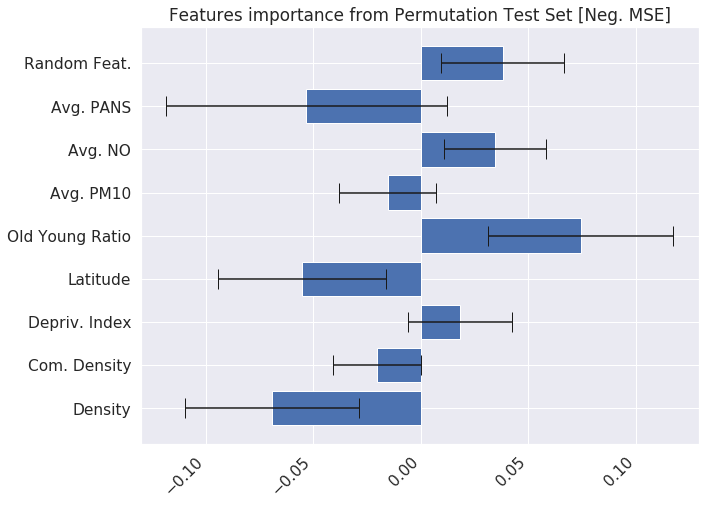

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                Old Young Ratio, Score: 0.08011 +/- 0.04647


<Figure size 432x288 with 0 Axes>

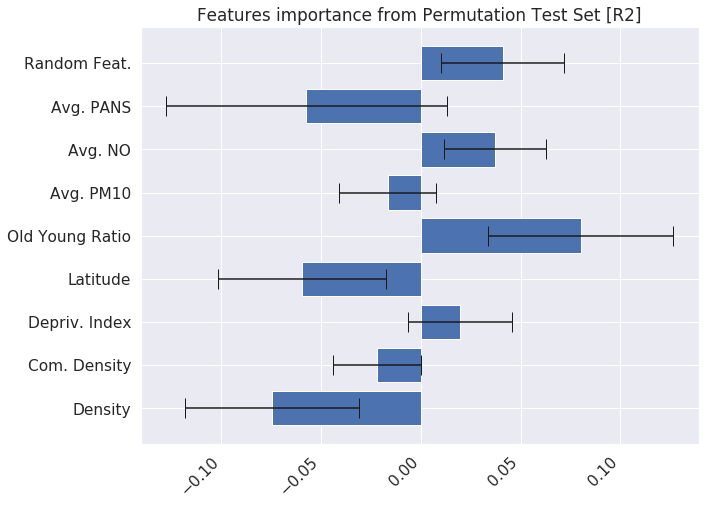

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.07926 +/- 0.01598
Feature:                       Latitude, Score: 0.08301 +/- 0.01945
Feature:                      Avg. PM10, Score: 0.71405 +/- 0.18891
Feature:                        Avg. NO, Score: 0.08079 +/- 0.02376
Feature:                      Avg. PANS, Score: 0.10869 +/- 0.03588


<Figure size 432x288 with 0 Axes>

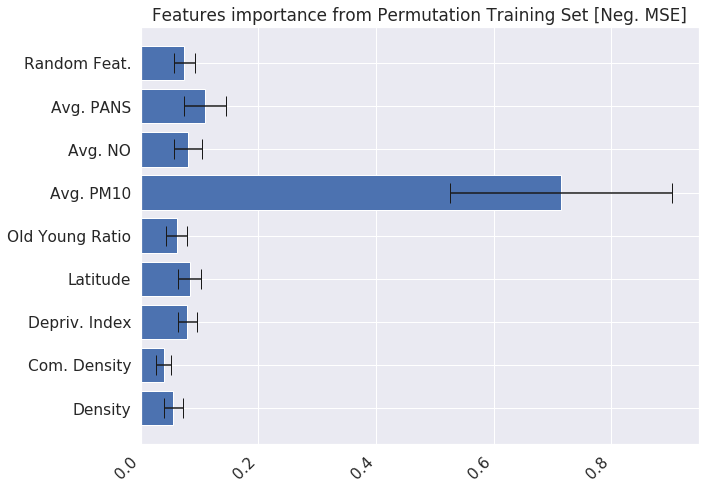

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                  Depriv. Index, Score: 0.06454 +/- 0.01301
Feature:                       Latitude, Score: 0.06760 +/- 0.01583
Feature:                      Avg. PM10, Score: 0.58144 +/- 0.15383
Feature:                        Avg. NO, Score: 0.06579 +/- 0.01934
Feature:                      Avg. PANS, Score: 0.08851 +/- 0.02921


<Figure size 432x288 with 0 Axes>

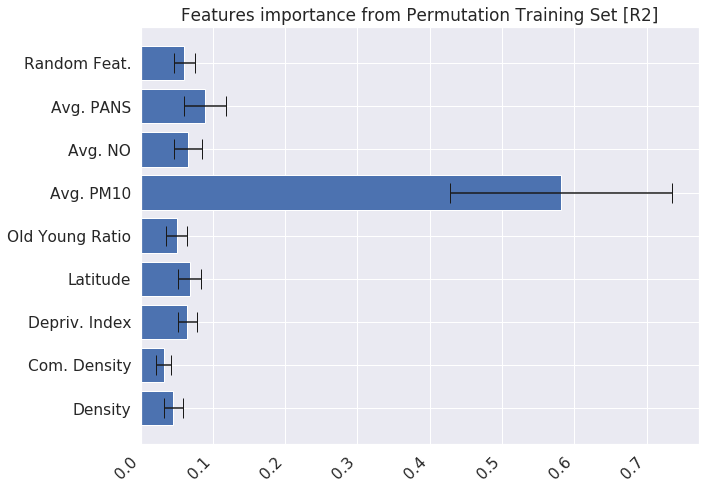

<Figure size 720x720 with 0 Axes>

In [14]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting ...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  1.06294  0.12932 
    Test set average RMSE:  1.04663  0.12830 

Prediction STD :    0.35282
True value STD :    1.04859
Difference in percentage:   66.35231

             Fullset RMSE:    0.91456
                       R2:    0.23930


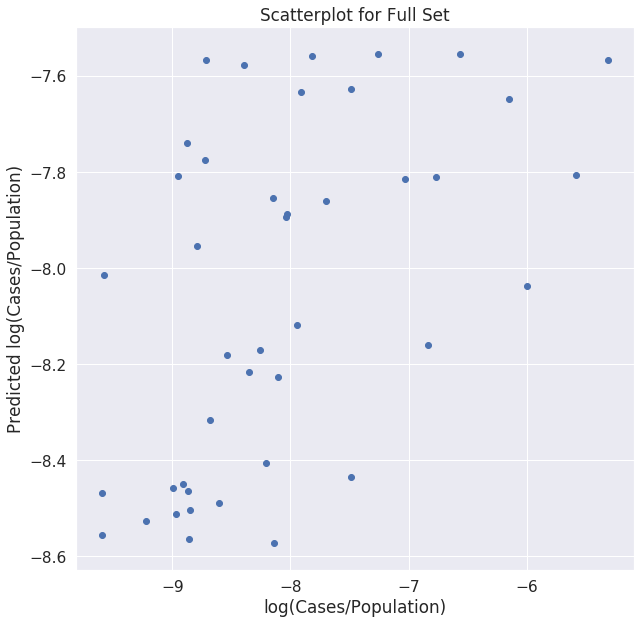

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00696 +/- 0.00626
Feature:                  Depriv. Index, Score: 0.01352 +/- 0.00639
Feature:                Old Young Ratio, Score: 0.06806 +/- 0.03735
Feature:                      Avg. PM10, Score: 0.00357 +/- 0.00227
Feature:                        Avg. NO, Score: 0.22653 +/- 0.08686
Feature:                      Avg. PANS, Score: 0.00337 +/- 0.00242


<Figure size 432x288 with 0 Axes>

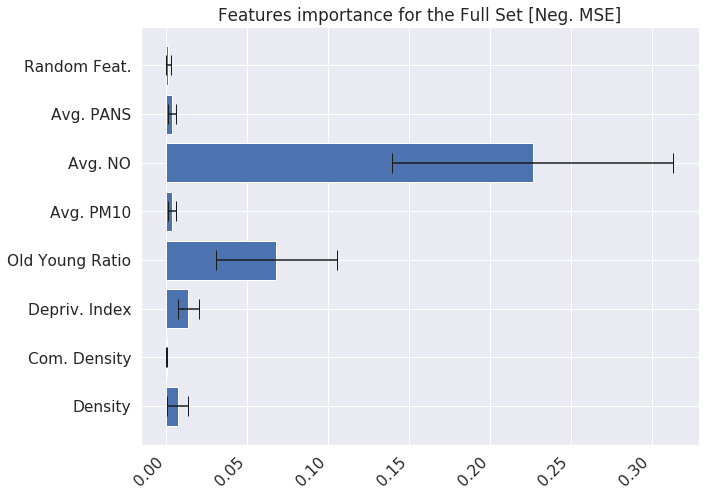

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.00633 +/- 0.00569
Feature:                  Depriv. Index, Score: 0.01230 +/- 0.00582
Feature:                Old Young Ratio, Score: 0.06190 +/- 0.03397
Feature:                      Avg. PM10, Score: 0.00325 +/- 0.00207
Feature:                        Avg. NO, Score: 0.20603 +/- 0.07900
Feature:                      Avg. PANS, Score: 0.00306 +/- 0.00220


<Figure size 432x288 with 0 Axes>

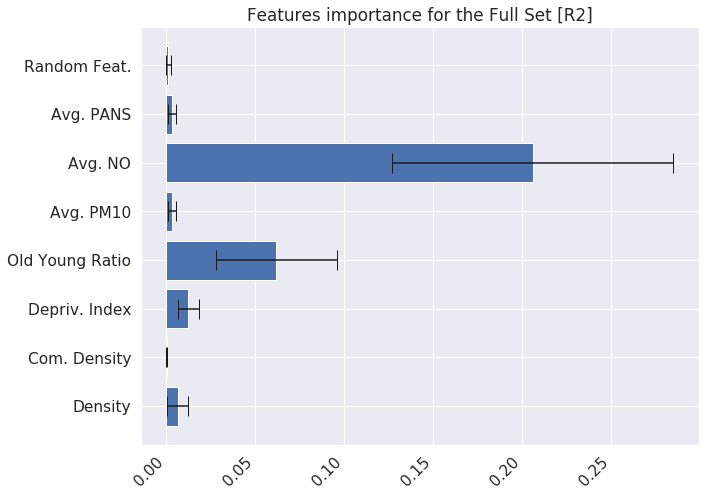

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.85872
                       R2:   -0.00002


<Figure size 432x288 with 0 Axes>

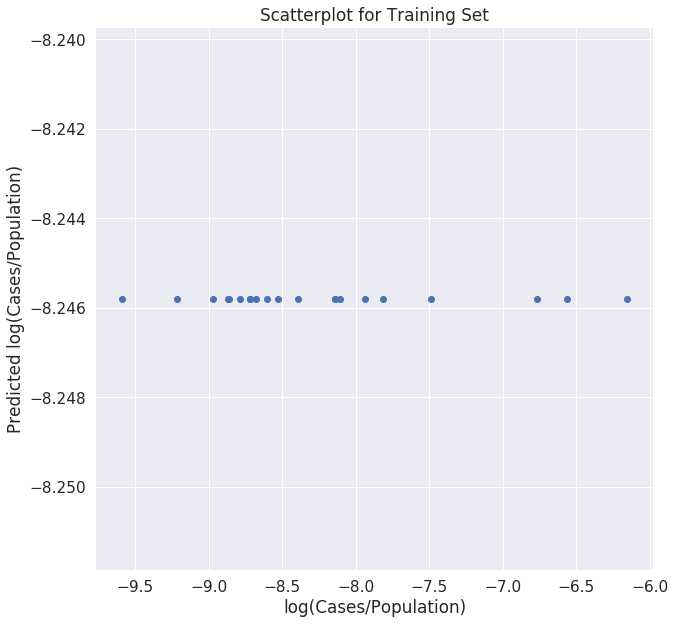

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.23499
                       R2:   -0.08888


<Figure size 432x288 with 0 Axes>

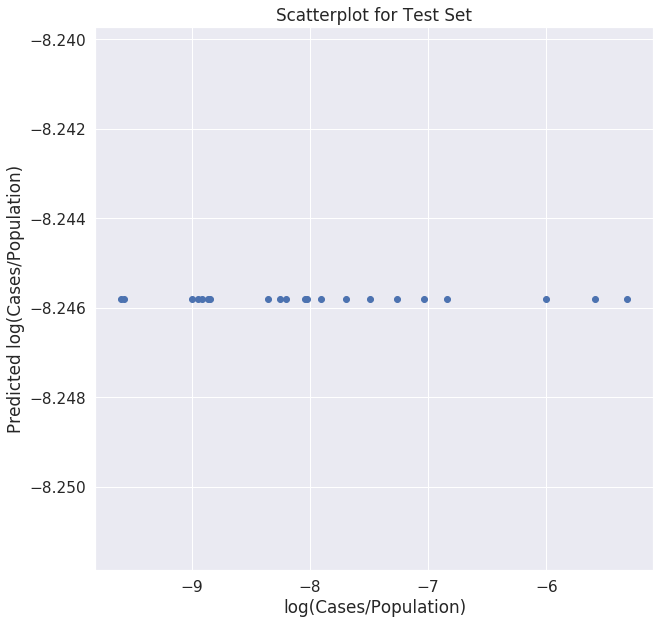

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 


/home/redo/Project_Covid/static_ML_analysis/smlmodule.py:935: RuntimeWarning: invalid value encountered in double_scalars
  featimport3[features[i]] /= totfi


<Figure size 432x288 with 0 Axes>

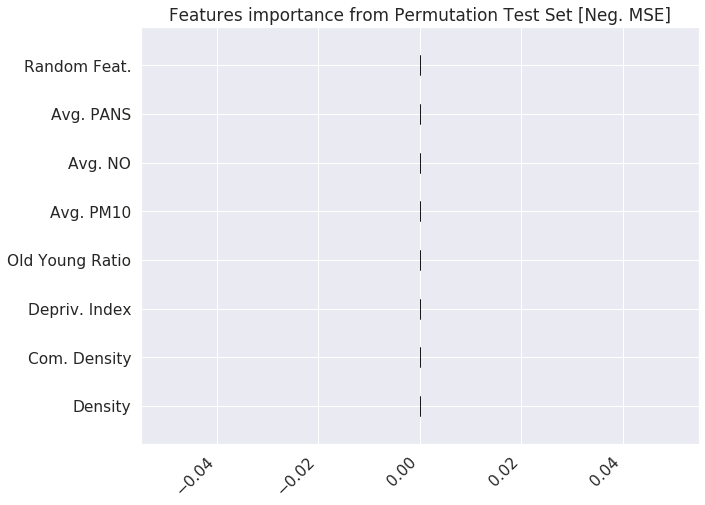

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 


/home/redo/Project_Covid/static_ML_analysis/smlmodule.py:980: RuntimeWarning: invalid value encountered in double_scalars
  featimport4[features[i]] /= totfi


<Figure size 432x288 with 0 Axes>

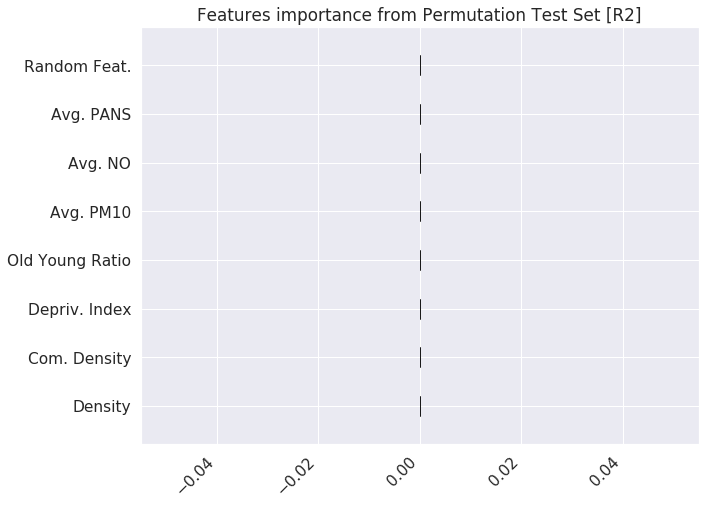

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 


<Figure size 432x288 with 0 Axes>

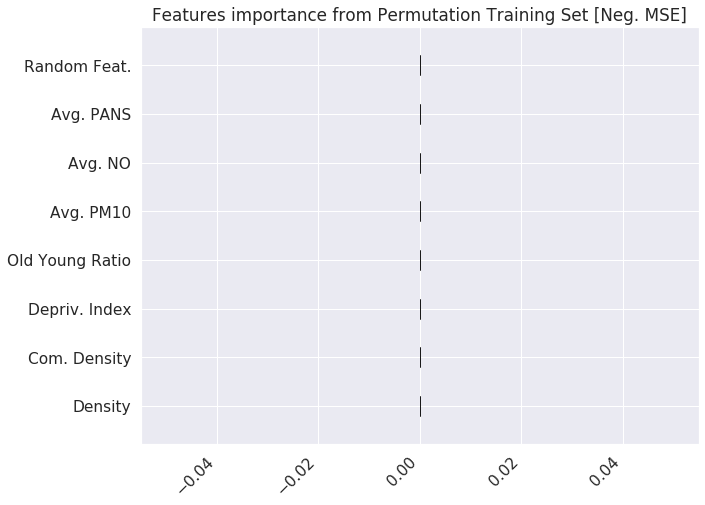

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 


<Figure size 432x288 with 0 Axes>

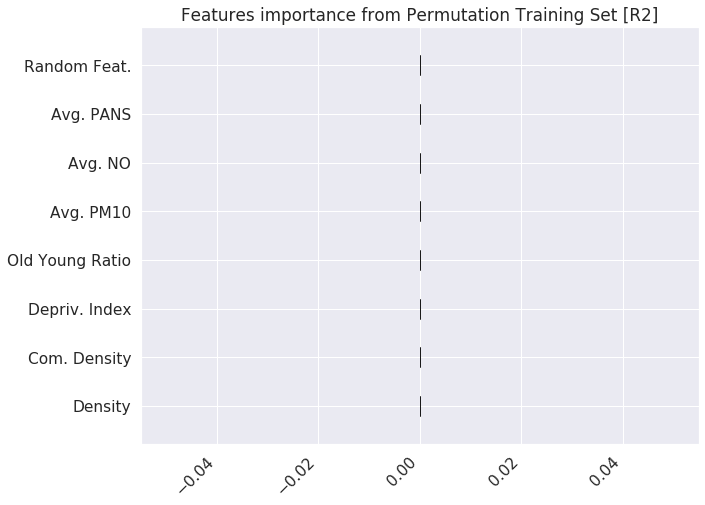

<Figure size 720x720 with 0 Axes>

In [15]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_testset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting ...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.38255  0.05086 
    Test set average RMSE:  1.03299  0.11945 

Prediction STD :    0.73279
True value STD :    1.04859
Difference in percentage:   30.11596

             Fullset RMSE:    0.35470
                       R2:    0.88558


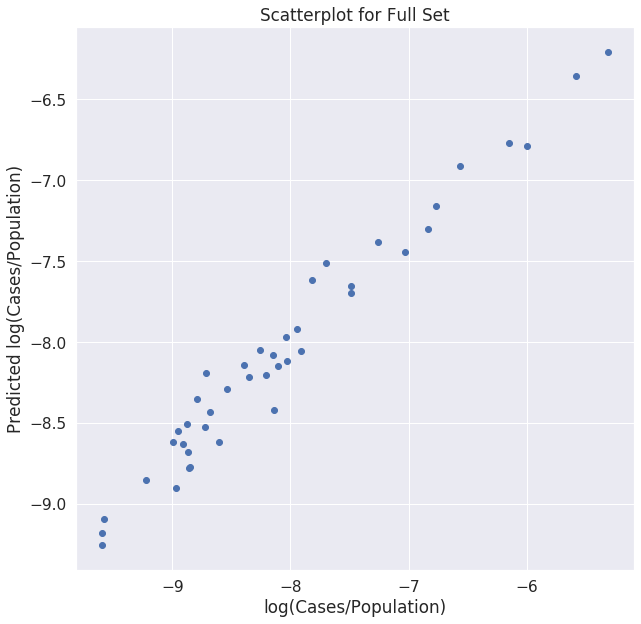

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.10900 +/- 0.01592
Feature:                  Depriv. Index, Score: 0.15980 +/- 0.02829
Feature:                Old Young Ratio, Score: 0.18866 +/- 0.03777
Feature:                      Avg. PM10, Score: 0.25283 +/- 0.03610
Feature:                        Avg. NO, Score: 0.23432 +/- 0.04280
Feature:                      Avg. PANS, Score: 0.11710 +/- 0.01466


<Figure size 432x288 with 0 Axes>

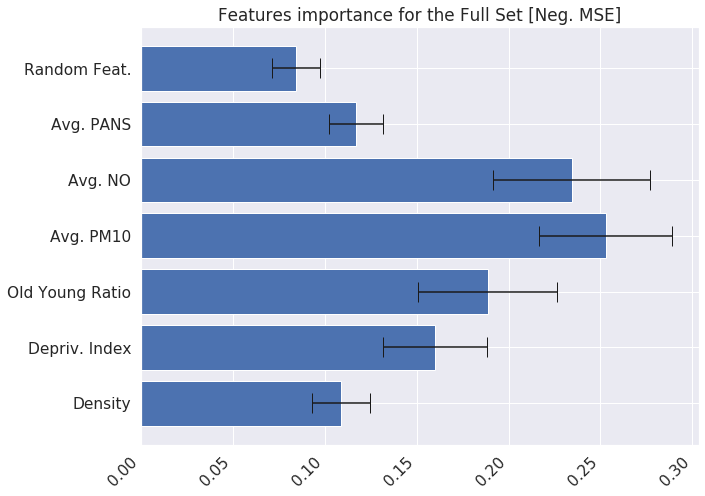

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.09913 +/- 0.01447
Feature:                  Depriv. Index, Score: 0.14533 +/- 0.02573
Feature:                Old Young Ratio, Score: 0.17158 +/- 0.03435
Feature:                      Avg. PM10, Score: 0.22995 +/- 0.03283
Feature:                        Avg. NO, Score: 0.21311 +/- 0.03892
Feature:                      Avg. PANS, Score: 0.10650 +/- 0.01333


<Figure size 432x288 with 0 Axes>

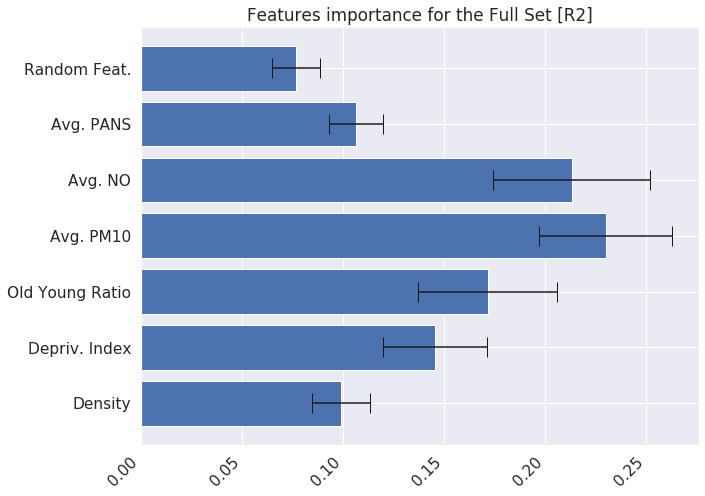

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.44694
                       R2:    0.84680


<Figure size 432x288 with 0 Axes>

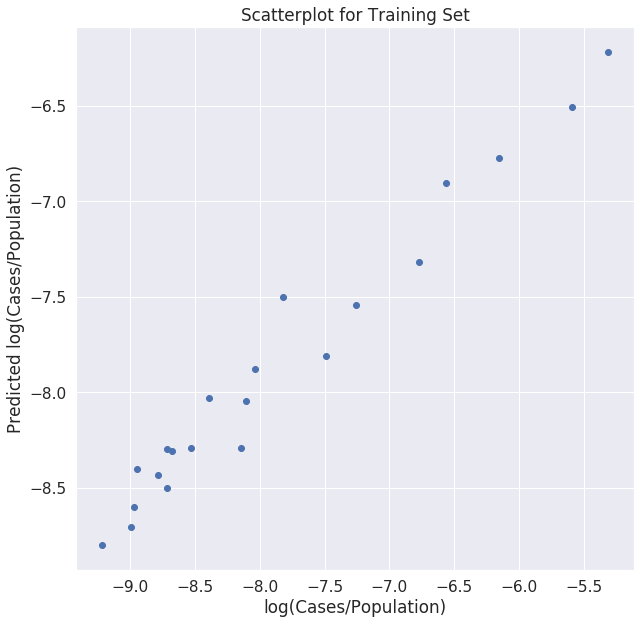

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.88154
                       R2:    0.04638


<Figure size 432x288 with 0 Axes>

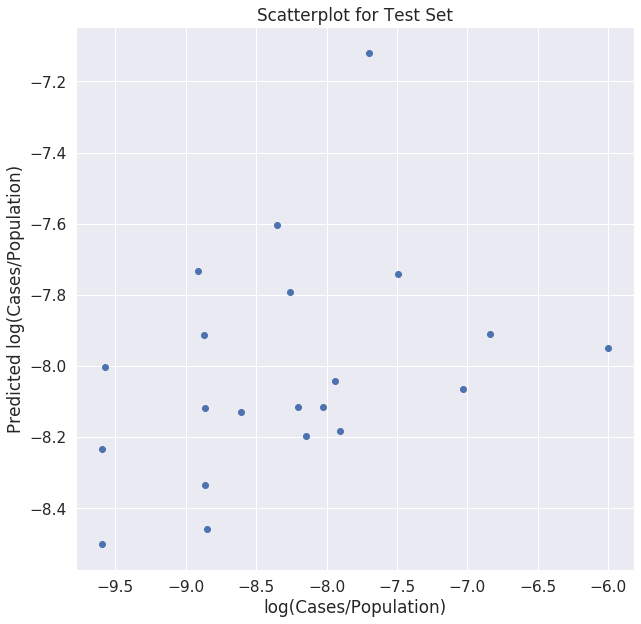

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.01181 +/- 0.01695
Feature:                  Depriv. Index, Score: 0.08790 +/- 0.05544
Feature:                Old Young Ratio, Score: 0.00689 +/- 0.06528
Feature:                      Avg. PM10, Score: 0.10896 +/- 0.06923
Feature:                        Avg. NO, Score: 0.10009 +/- 0.06500
Feature:                      Avg. PANS, Score: 0.04961 +/- 0.02264


<Figure size 432x288 with 0 Axes>

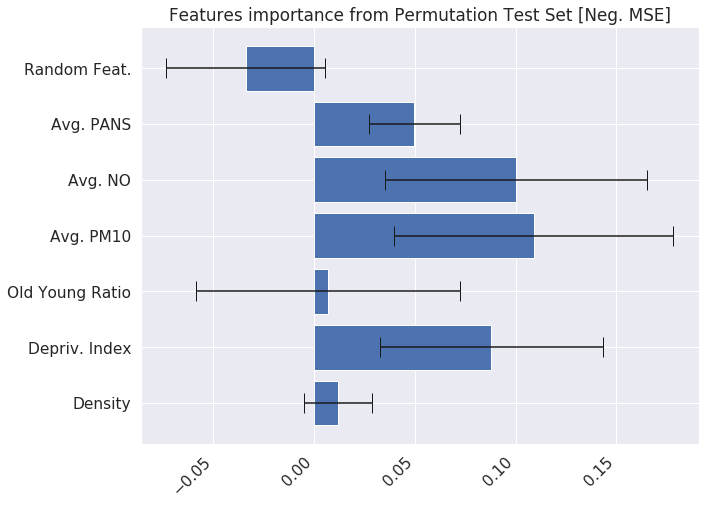

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.01449 +/- 0.02079
Feature:                  Depriv. Index, Score: 0.10786 +/- 0.06803
Feature:                Old Young Ratio, Score: 0.00846 +/- 0.08010
Feature:                      Avg. PM10, Score: 0.13370 +/- 0.08495
Feature:                        Avg. NO, Score: 0.12282 +/- 0.07976
Feature:                      Avg. PANS, Score: 0.06088 +/- 0.02778


<Figure size 432x288 with 0 Axes>

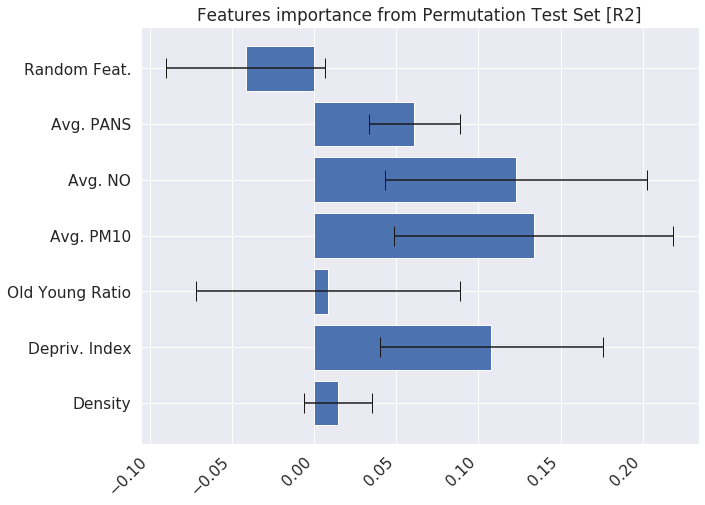

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.14921 +/- 0.03974
Feature:                Old Young Ratio, Score: 0.21171 +/- 0.05157
Feature:                      Avg. PM10, Score: 0.33422 +/- 0.06090
Feature:                        Avg. NO, Score: 0.20560 +/- 0.05819


<Figure size 432x288 with 0 Axes>

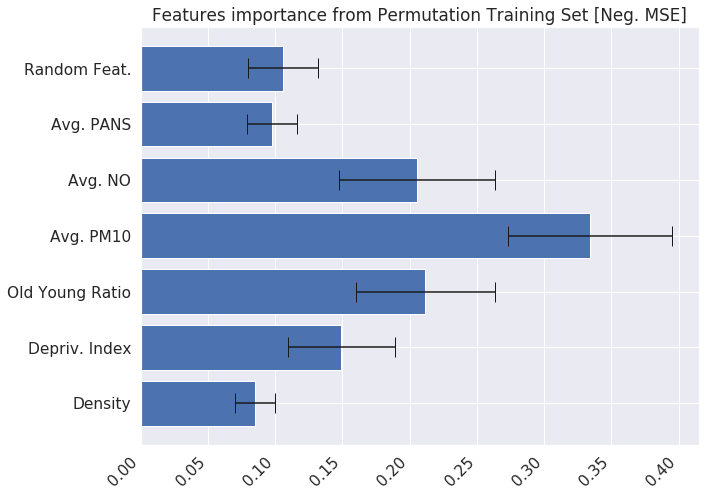

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                  Depriv. Index, Score: 0.11443 +/- 0.03048
Feature:                Old Young Ratio, Score: 0.16237 +/- 0.03955
Feature:                      Avg. PM10, Score: 0.25633 +/- 0.04671
Feature:                        Avg. NO, Score: 0.15769 +/- 0.04463


<Figure size 432x288 with 0 Axes>

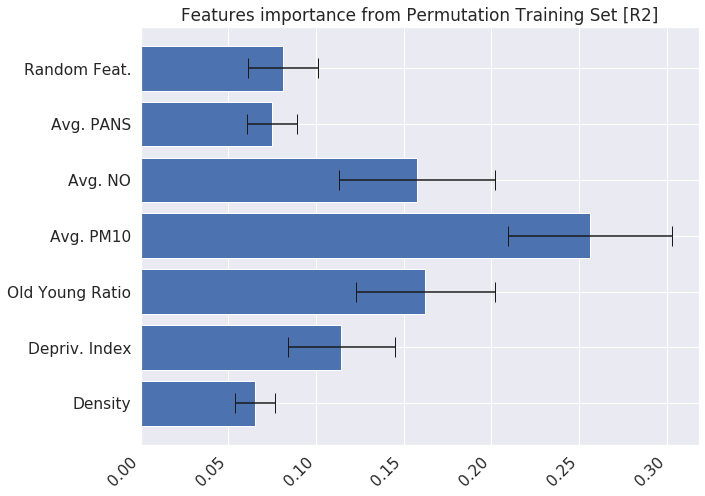

<Figure size 720x720 with 0 Axes>

In [16]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Using mutiple split test and training 

In [17]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'random_state': 1}


In [18]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.39702 +/-  0.05356 
    Test set average RMSE:  1.08940 +/-  0.11929 
  Training set average R2:  0.84748 +/-  0.02513 
      Test set average R2: -0.12276 +/-  0.26905 
Taining:
             Density ,    0.06789 +/-    0.06788 ,   -0.00978 +/-    0.03893 ,    4.00000 ,    8.00000 ,    3.00000 ,    3.00000
        Com. Density ,    0.02979 +/-    0.01899 ,   -0.00359 +/-    0.02061 ,    0.00000 ,    0.00000 ,    0.00000 ,    4.00000
       Depriv. Index ,    0.09125 +/-    0.08322 ,    0.01431 +/-    0.03443 ,    6.00000 ,   12.00000 ,    5.00000 ,   10.00000
            Latitude ,    0.07516 +/-    0.07105 ,   -0.01676 +/-    0.05231 ,    1.00000 ,    9.00000 ,    1.00000 ,    3.00000
     Old Young Ratio ,    0.17440 +/-    0.15323 ,    0.05158 +/-    0.07294 ,   26.00000 ,   21.00000 ,   21.00000 ,   31.00000
           Avg. PM10 ,    0.23980 +/-    0.20580 ,    0

<Figure size 720x720 with 0 Axes>

In [19]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500,
 'random_state': 1}


In [20]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.37173 +/-  0.04617 
    Test set average RMSE:  1.06063 +/-  0.11092 
  Training set average R2:  0.86636 +/-  0.01862 
      Test set average R2: -0.07619 +/-  0.29367 
Taining:
             Density ,    0.09141 +/-    0.03815 ,   -0.01115 +/-    0.03343 ,    4.00000 ,    3.00000 ,    0.00000 ,    2.00000
        Com. Density ,    0.05746 +/-    0.02452 ,   -0.01017 +/-    0.02478 ,    0.00000 ,    1.00000 ,    0.00000 ,    2.00000
       Depriv. Index ,    0.12222 +/-    0.05325 ,    0.04442 +/-    0.03465 ,    8.00000 ,   19.00000 ,   23.00000 ,   19.00000
     Old Young Ratio ,    0.15602 +/-    0.07572 ,    0.03930 +/-    0.05394 ,   26.00000 ,   22.00000 ,   18.00000 ,   24.00000
           Avg. PM10 ,    0.15040 +/-    0.06693 ,    0.05937 +/-    0.05948 ,   22.00000 ,   23.00000 ,   30.00000 ,   26.00000
             Avg. NO ,    0.17348 +/-    0.07619 ,    0

<Figure size 720x720 with 0 Axes>

In [21]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 1}


In [22]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.36441 +/-  0.05527 
    Test set average RMSE:  1.06497 +/-  0.12362 
  Training set average R2:  0.86846 +/-  0.02382 
      Test set average R2: -0.05648 +/-  0.26670 
Taining:
             Density ,    0.08459 +/-    0.03606 ,   -0.00296 +/-    0.04312 ,    3.00000 ,    3.00000 ,    0.00000 ,    3.00000
       Depriv. Index ,    0.11591 +/-    0.05326 ,    0.03594 +/-    0.04862 ,    5.00000 ,   12.00000 ,   10.00000 ,   24.00000
     Old Young Ratio ,    0.16351 +/-    0.06418 ,    0.05324 +/-    0.05943 ,   31.00000 ,   20.00000 ,   23.00000 ,   21.00000
           Avg. PM10 ,    0.15765 +/-    0.06715 ,    0.06446 +/-    0.06483 ,   15.00000 ,   34.00000 ,   35.00000 ,   22.00000
             Avg. NO ,    0.20438 +/-    0.09758 ,    0.04733 +/-    0.10100 ,   45.00000 ,   25.00000 ,   29.00000 ,   21.00000
           Avg. PANS ,    0.09228 +/-    0.04630 ,    0

<Figure size 720x720 with 0 Axes>